In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import requests
import sys
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import time
import ta
import warnings
from statistics import median, mean, stdev
import seaborn as sns
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
#!{sys.executable} -m pip install seaborn
import time
import concurrent
import multiprocessing.dummy as mp 
from multiprocessing import Pool
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool

Extract Data from finviz

In [2]:
def finviz_pull(url):
    # Finviz with filters: Average Volume > 500k / RSI 40 / Current Volume > 1M / Market Cap +Small (no Micro)
    #url = 'https://finviz.com/screener.ashx?v=131&f=sh_avgvol_o500,sh_curvol_o1000,ta_rsi_os40'
    #url = 'https://finviz.com/screener.ashx?v=131&f=cap_smallover,sh_avgvol_o500,sh_curvol_o1000,ta_rsi_os40'
    #url = 'https://finviz.com/screener.ashx?v=131&f=cap_smallover,sh_avgvol_o500,sh_curvol_o500&ft=3&o=-volume'
    
    # Headers
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    
    # Extract data from Finviz - parse html
    screener = requests.get(url, headers = headers, verify=False)
    soup = BeautifulSoup(screener.text, 'html.parser')

    # Figure out number of stocks
    total_stocks_element = soup.find(class_ = 'count-text').text[7:]
    stop_position = total_stocks_element.find(' ')
    total_stocks = int(total_stocks_element[:stop_position])
    
    # Empty list to store stocks
    my_stocks = []

    # Pages of stocks
    for page in range(1, total_stocks, 20):
        # Create new url
        new_url = url + '&r=' + str(page)

        # Pull data and parse html
        stock_data = requests.get(new_url, headers = headers)
        soup = BeautifulSoup(stock_data.text, 'html.parser')

        # Table with stocks
        table_element_1 = soup.find_all(class_='table-dark-row-cp')
        table_element_2 = soup.find_all(class_='table-light-row-cp')
        table_element = table_element_1 + table_element_2

        # For each line extract the symbol, name and industry
        for idx, row in enumerate(table_element):
            # Creating table with all 'a' elements
            symbol_table = row.find_all('a')
            
            # Symbol
            symbol = symbol_table[1].text
            # Name
            symbol_name = symbol_table[2].text
            # Industry
            symbol_sector = symbol_table[3].text
            
            # Append all
            my_stocks.append([symbol, symbol_name, symbol_sector])
            
    return my_stocks

Function to query data

In [3]:
def yahoo_finance_query(symbol, period1_date, period2_date, interval='30m', pre_post = 'true'):
    # Convert dates to timestamps
    period1 = int(time.mktime(time.strptime((period1_date + ' 00:00:00'), '%Y-%m-%d %H:%M:%S')))
    period2 = int(time.mktime(time.strptime((period2_date), '%Y-%m-%d %H:%M:%S')))
    
    # Headers
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    
    # Proxies
    proxies = {
                "http": 'http://103.28.121.58:3128', 
                "https": 'http://103.28.121.58:3128'}

    # Create url
    url = 'https://query1.finance.yahoo.com/v8/finance/chart/{}?symbol={}&period1={}&period2={}&interval={}&includePrePost={}'.format(symbol, symbol, period1, period2, interval, pre_post)
    print(url)
    # Get data
    stock_price = requests.get(url, headers=headers, verify=False)#, proxies=proxies)
    
    # Return JSON
    price_json = json.loads(stock_price.text)
    return price_json

Parse data out of JSON and create a dataframe

In [4]:
def create_dataframe(price_json):
    
    dict_keys = timestamps = price_json['chart']['result'][0].keys()
    
    if 'timestamp' in dict_keys:
    
        # Parse data out of JSON
        timestamps = price_json['chart']['result'][0]['timestamp']
        high_price = price_json['chart']['result'][0]['indicators']['quote'][0]['high']
        volume = price_json['chart']['result'][0]['indicators']['quote'][0]['volume']
        open_price = price_json['chart']['result'][0]['indicators']['quote'][0]['open']
        low_price = price_json['chart']['result'][0]['indicators']['quote'][0]['low']
        close_price = price_json['chart']['result'][0]['indicators']['quote'][0]['close']

        # Zip all lists
        zipped = list(zip(timestamps, high_price, low_price, open_price, close_price, volume))

        # Column Names
        column_names = ['timestamp', 'high_price', 'low_price', 'open_price', 'close_price', 'volume']

        # Create Dataframe, add column with symbol and return df
        df = pd.DataFrame(zipped, columns = column_names)
        df['symbol'] = price_json['chart']['result'][0]['meta']['symbol']

        return df
    
    else:
        return 'Nothing'

Create Function to do all of this for a list of symbols

In [5]:
def get_prices(symbols_list
               , period1
               , period2 = datetime.today().strftime("%Y-%m-%d %H:%M:%S")
               , interval='1d'
               , pre_post = 'true'):
    
    # Create % completion
    length = len(symbols_list)
    
    # Go through list of symbols, get JSON and create dataframe
    for idx, symbol in enumerate(symbols_list):
        
        # Pull price and put in a dataframe
        price_json = yahoo_finance_query(symbol[0], period1, period2, interval, pre_post)
        
        df_symbol = create_dataframe(price_json)
        
        if type(df_symbol) == pd.DataFrame:
        
            # Add Name and Industry columns
            df_symbol['name'] = symbol[1]
            df_symbol['industry'] = symbol[2]

            #If this is the first symbol it will create a dataframe, otherwise, it appends the data
            if idx == 0:
                df_master = df_symbol
            else:
                df_master = df_master.append(df_symbol)

            # Print Completion
            print('Running Yahoo Finance Query: ' + str(idx + 1) + ' of ' + str(length) + ' - '+ symbol[0] + ' - ' + str(round((((idx + 1)/length) * 100),2)) + '%')

            if idx % 100 == 0:
                time.sleep(5)
        
    # Convert timestamp column to datetime and return df_master
    df_master['timestamp'] = pd.to_datetime(df_master['timestamp'], unit='s')
   
    # Add interval column
    df_master['interval'] = interval
    
    # Reset index
    #df_master.reset_index(inplace=True, drop=True)
    
    # Just date
    df_master['just_date'] = df_master['timestamp'].dt.date
    
    print('Done')
    
    return df_master

# Fourth Iteration

In [6]:
def run_indicators_2(df
                   , symbol
                   , NaN = np.nan
                   , min_max_rows = [5, 10, 15, 20, 25, 30, 60, 90, 120]):
    
    # RSI Bins
    bins = list(range(0,101,10))
    labels = list(range(10))
    
    # Add empty Columns
    df['low_is_min_7'] = NaN
    df['low_is_min_14'] = NaN
    
    # Add ta features filling NaN values
    df_2 = df[df['symbol'] == symbol]
    
    # Create empty_df
    empty_df = df.copy()
    empty_df['momentum_rsi'] = 0
    empty_df['index'] = 0
    empty_df = empty_df[empty_df['symbol'] == 'Nothing Here']
    
    # Check if min == to 7 day min
    #df_2['low_is_min_7'].mask((df_2['low_price'] == df_2['min_7']), True, inplace=True)
    #df_2['low_is_min_14'].mask((df_2['low_price'] == df_2['min_14']), True, inplace=True)
    
    # Check for number of days
    length = len(df_2)
    
    if length > 14:
        # Close price shift
        df_2['close_price_shift'] = df_2['close_price'].shift(-1)
        
         # Shift prices one day
        df_2[['high_previous', 'low_previous', 'close_previous', 'open_previous']] = df_2[['high_price', 'low_price', 'close_price', 'open_price']].shift(1)
        
        # Support and Resistance Prices
        for row in min_max_rows:
            # Column names
            min_column_name = 'low_min_d' + str(row)
            min_column_name_shift = 'low_min_d' + str(row) + '_shift1_' + str(row)
            min_column_name_shift2 = 'low_min_d' + str(row) + '_shift2_' + str(2 * row)
            max_column_name = 'high_max_d' + str(row)
            max_column_name_shift = 'high_max_d' + str(row) + '_shif1_' + str(row)
            max_column_name_shift2 = 'high_max_d' + str(row) + '_shif2_' + str(2 * row)
            close_column_name = 'close_min_d' + str(row)
            close_column_name2 = 'close_max_d' + str(row)
            open_column_name = 'open_min_d' + str(row)
            open_column_name2 = 'open_max_d' + str(row)
            
            # Calculations
            df_2[min_column_name] = df_2['low_price'].rolling(row).min()
            df_2[min_column_name_shift] = df_2[min_column_name].shift(row)
            df_2[min_column_name_shift2] = df_2[min_column_name].shift(row * 2)
            df_2[max_column_name] = df_2['high_price'].rolling(row).max()
            df_2[max_column_name_shift] = df_2[max_column_name].shift(row)
            df_2[max_column_name_shift2] = df_2[max_column_name].shift(row * 2)
            df_2[close_column_name] = df_2['close_price'].rolling(row).min()
            df_2[open_column_name] = df_2['open_price'].rolling(row).min()
            df_2[close_column_name2] = df_2['close_price'].rolling(row).max()
            df_2[open_column_name2] = df_2['open_price'].rolling(row).max()
        
        # Reset Index
        #df_2 = df_2.reset_index()
        
        # Year from timestamp
        df_2['year'] = pd.DatetimeIndex(df_2['timestamp']).year
        
        # Shift Price
        df_2['close_price_shift'] = df_2['close_price'].shift(1)
        df_2['daily_return'] = (df_2['close_price'] / df_2['close_price_shift'])

        # Calculate Past Returns
        df_2['moving_1d_return'] = (df_2['daily_return']).rolling(window=1).apply(np.prod, raw=True)
        df_2['moving_2d_return'] = (df_2['daily_return']).rolling(window=2).apply(np.prod, raw=True)
        df_2['moving_3d_return'] = (df_2['daily_return']).rolling(window=3).apply(np.prod, raw=True)
        df_2['moving_5d_return'] = (df_2['daily_return']).rolling(window=5).apply(np.prod, raw=True)
        df_2['moving_7d_return'] = (df_2['daily_return']).rolling(window=7).apply(np.prod, raw=True)
        
        # Calculate min daily moves
        df_2['moving_30d_return_mean'] = df_2['daily_return'].rolling(window=30).mean()
        df_2['moving_30d_return_std'] = df_2['daily_return'].rolling(window=30).std()
        df_2['moving_60d_return_mean'] = df_2['daily_return'].rolling(window=60).mean()
        df_2['moving_60d_return_std'] = df_2['daily_return'].rolling(window=60).std()
        df_2['moving_90d_return_mean'] = df_2['daily_return'].rolling(window=90).mean()
        df_2['moving_90d_return_std'] = df_2['daily_return'].rolling(window=90).std()
        
        # Calculate Avg - 2 * Std
        df_2['moving_30d_min_return'] = df_2['moving_30d_return_mean'] - (2 * df_2['moving_30d_return_std'])
        df_2['moving_60d_min_return'] = df_2['moving_60d_return_mean'] - (2 * df_2['moving_60d_return_std'])
        df_2['moving_90d_min_return'] = df_2['moving_90d_return_mean'] - (2 * df_2['moving_90d_return_std'])
        
        # Simple Moving Average
        df_2['sma_10d'] = df_2['close_price'].rolling(window=10).mean()
        df_2['sma_10d_shift'] = df_2['sma_10d'].shift(1) 
        df_2['sma_10d_coef'] = (-df_2['sma_10d'].shift(10) + df_2['sma_10d']) / 2
        df_2['sma_10d_std'] = df_2['close_price'].rolling(window=10).std()
        df_2['stationary_sma_10d'] = df_2['close_price'] - df_2['sma_10d']
        df_2['stationary_sma_10d_zscore'] = df_2['stationary_sma_10d'] / df_2['sma_10d_std']
        df_2['stationary_sma_10d_zscore_shift'] = df_2['stationary_sma_10d_zscore'].shift(5)
        df_2['stationary_sma_10d_zscore_shift_2'] = df_2['stationary_sma_10d_zscore'].shift(10)
        df_2['stationary_sma_10d_zscore_min'] = df_2['stationary_sma_10d_zscore'].rolling(window=10).min()
        df_2['stationary_sma_10d_zscore_max'] = df_2['stationary_sma_10d_zscore'].rolling(window=10).max()
        df_2['stationary_sma_10d_zscore_min_shift_1'] = df_2['stationary_sma_10d_zscore_min'].shift(5)
        df_2['stationary_sma_10d_zscore_min_shift_2'] = df_2['stationary_sma_10d_zscore_min'].shift(10)
        df_2['stationary_sma_10d_zscore_min_shift_3'] = df_2['stationary_sma_10d_zscore_min'].shift(15)
        df_2['stationary_sma_10d_zscore_min_all'] = df_2[['stationary_sma_10d_zscore_min_shift_1', 'stationary_sma_10d_zscore_min_shift_2', 'stationary_sma_10d_zscore_min_shift_3']].min(axis=1)
        df_2['stationary_sma_10d_zscore_min_all_shift'] = df_2['stationary_sma_10d_zscore_min_all'].shift(5)
        df_2['stationary_sma_10d_zscore_min_all_shift_2'] = df_2['stationary_sma_10d_zscore_min_all'].shift(10)
        
        df_2['sma_20d'] = df_2['close_price'].rolling(window=20).mean()
        df_2['sma_20d_shift'] = df_2['sma_20d'].shift(1) 
        df_2['sma_20d_coef'] = (-df_2['sma_20d'].shift(10) + df_2['sma_20d']) / 2
        df_2['sma_20d_std'] = df_2['close_price'].rolling(window=20).std()
        df_2['stationary_sma_20d'] = df_2['close_price'] - df_2['sma_20d']
        df_2['stationary_sma_20d_zscore'] = df_2['stationary_sma_20d'] / df_2['sma_20d_std']
        df_2['stationary_sma_20d_zscore_shift'] = df_2['stationary_sma_20d_zscore'].shift(5)
        df_2['stationary_sma_20d_zscore_shift_2'] = df_2['stationary_sma_20d_zscore'].shift(10)
        df_2['stationary_sma_20d_zscore_min'] = df_2['stationary_sma_20d_zscore'].rolling(window=20).min()
        df_2['stationary_sma_20d_zscore_max'] = df_2['stationary_sma_20d_zscore'].rolling(window=100).max()
        df_2['stationary_sma_20d_zscore_min_shift_1'] = df_2['stationary_sma_20d_zscore_min'].shift(20)
        df_2['stationary_sma_20d_zscore_min_shift_2'] = df_2['stationary_sma_20d_zscore_min'].shift(40)
        df_2['stationary_sma_20d_zscore_min_shift_3'] = df_2['stationary_sma_20d_zscore_min'].shift(60)
        df_2['stationary_sma_20d_zscore_min_all'] = df_2[['stationary_sma_20d_zscore_min_shift_1', 'stationary_sma_20d_zscore_min_shift_2', 'stationary_sma_20d_zscore_min_shift_3']].min(axis=1)
        df_2['stationary_sma_20d_zscore_min_all_shift'] = df_2['stationary_sma_20d_zscore_min_all'].shift(5)
        df_2['stationary_sma_20d_zscore_min_all_shift_2'] = df_2['stationary_sma_20d_zscore_min_all'].shift(10)
        
        df_2['sma_100d'] = df_2['close_price'].rolling(window=100).mean()
        df_2['sma_100d_shift'] = df_2['sma_100d'].shift(1)
        df_2['sma_100d_std'] = df_2['close_price'].rolling(window=100).std()
        df_2['stationary_sma_100d'] = df_2['close_price'] - df_2['sma_100d']
        df_2['stationary_sma_100d_shift'] = df_2['stationary_sma_100d'].shift(1)
        df_2['stationary_sma_100d_zscore'] = df_2['stationary_sma_100d'] / df_2['sma_100d_std']
        df_2['stationary_sma_100d_zscore_min'] = df_2['stationary_sma_100d_zscore'].rolling(window=100).min()
        df_2['stationary_sma_100d_zscore_max'] = df_2['stationary_sma_100d_zscore'].rolling(window=100).max()
        df_2['stationary_sma_100d_zscore_min_shift_1'] = df_2['stationary_sma_100d_zscore_min'].shift(50)
        df_2['stationary_sma_100d_zscore_min_shift_2'] = df_2['stationary_sma_100d_zscore_min'].shift(100)
        df_2['stationary_sma_100d_zscore_min_shift_3'] = df_2['stationary_sma_100d_zscore_min'].shift(150)
        df_2['stationary_sma_100d_zscore_min_all'] = df_2[['stationary_sma_100d_zscore_min_shift_1', 'stationary_sma_100d_zscore_min_shift_2', 'stationary_sma_100d_zscore_min_shift_3']].min(axis=1)
        
        df_2['sma_200d'] = df_2['close_price'].rolling(window=200).mean()
        df_2['sma_200d_shift'] = df_2['sma_200d'].shift(1)
        df_2['sma_200d_std'] = df_2['close_price'].rolling(window=200).std()
        df_2['stationary_sma_200d'] = df_2['close_price'] - df_2['sma_200d']
        df_2['stationary_sma_200d_shift'] = df_2['stationary_sma_200d'].shift(1)
        df_2['stationary_sma_200d_zscore'] = df_2['stationary_sma_200d'] / df_2['sma_200d_std']
        df_2['stationary_sma_200d_zscore_min'] = df_2['stationary_sma_200d_zscore'].rolling(window=200).min()
        df_2['stationary_sma_200d_zscore_min_shift_1'] = df_2['stationary_sma_200d_zscore_min'].shift(100)
        df_2['stationary_sma_200d_zscore_min_shift_2'] = df_2['stationary_sma_200d_zscore_min'].shift(200)
        df_2['stationary_sma_200d_zscore_min_shift_3'] = df_2['stationary_sma_200d_zscore_min'].shift(300)
        df_2['stationary_sma_200d_zscore_min_all'] = df_2[['stationary_sma_200d_zscore_min_shift_1', 'stationary_sma_200d_zscore_min_shift_2', 'stationary_sma_200d_zscore_min_shift_3']].min(axis=1)
        #df_2['sma_200d'] = df_2['close_price'].rolling(window=200).mean()
        
        # Get RSI
        df_2['momentum_rsi'] = ta.momentum.RSIIndicator(close=df_2['close_price'], n=7).rsi()
        df_2['momentum_rsi_low'] = ta.momentum.RSIIndicator(close=df_2['low_price'], n=7).rsi()
        df_2['momentum_rsi_high'] = ta.momentum.RSIIndicator(close=df_2['high_price'], n=7).rsi()
        
        # Create bins of rsi and label them 
        df_2['rsi_bins'] = pd.cut(df_2['momentum_rsi'], bins=bins, labels=labels)
        df_2['rsi_bins'] = pd.to_numeric(df_2['rsi_bins'], errors='coerce')
        df_2['rsi_bins_low'] = pd.cut(df_2['momentum_rsi_low'], bins=bins, labels=labels)
        df_2['rsi_bins_low'] = pd.to_numeric(df_2['rsi_bins_low'], errors='coerce')
        df_2['rsi_bins_high'] = pd.cut(df_2['momentum_rsi_high'], bins=bins, labels=labels)
        df_2['rsi_bins_high'] = pd.to_numeric(df_2['rsi_bins_high'], errors='coerce')
        
        # Create a shift of the bin, to compare current with the previous
        df_2['rsi_bins_shift_1d'] = df_2['rsi_bins'].shift(1).fillna(0)
        df_2['rsi_bins_shift_2d'] = df_2['rsi_bins'].shift(2).fillna(0)
        df_2['rsi_bins_shift_3d'] = df_2['rsi_bins'].shift(3).fillna(0)
        df_2['rsi_bins_shift_1d_low'] = df_2['rsi_bins_low'].shift(1).fillna(0)
        df_2['rsi_bins_shift_2d_low'] = df_2['rsi_bins_low'].shift(2).fillna(0)
        df_2['rsi_bins_shift_3d_low'] = df_2['rsi_bins_low'].shift(3).fillna(0)
        df_2['rsi_bins_shift_1d_high'] = df_2['rsi_bins_high'].shift(1).fillna(0)
        df_2['rsi_bins_shift_2d_high'] = df_2['rsi_bins_high'].shift(2).fillna(0)
        df_2['rsi_bins_shift_3d_high'] = df_2['rsi_bins_high'].shift(3).fillna(0)
        
        # Get min rsi
        df_2['rsi_7'] = df_2['momentum_rsi'].rolling(7).min()
        df_2['rsi_14'] = df_2['momentum_rsi'].rolling(14).min()
        df_2['rsi_21'] = df_2['momentum_rsi'].rolling(21).min()
        df_2['rsi_28'] = df_2['momentum_rsi'].rolling(28).min()
        df_2['rsi_35'] = df_2['momentum_rsi'].rolling(35).min()
        df_2['rsi_70'] = df_2['momentum_rsi'].rolling(70).min()
        df_2['rsi_105'] = df_2['momentum_rsi'].rolling(105).min()
        df_2['rsi_140'] = df_2['momentum_rsi'].rolling(140).min()
        df_2['rsi_175'] = df_2['momentum_rsi'].rolling(175).min()
        df_2['rsi_210'] = df_2['momentum_rsi'].rolling(210).min()
        
        # Get rsi std
        df_2['rsi_std_35'] = df_2['rsi_bins'].rolling(35).std()
        df_2['rsi_std_70'] = df_2['rsi_bins'].rolling(70).std()
        df_2['rsi_std_140'] = df_2['rsi_bins'].rolling(140).std()
        df_2['rsi_avg_35'] = df_2['rsi_bins'].rolling(35).mean()
        df_2['rsi_avg_70'] = df_2['rsi_bins'].rolling(70).mean()
        df_2['rsi_avg_140'] = df_2['rsi_bins'].rolling(140).mean()
        
        # Get min rsi
        df_2['rsi_35_min_bin'] = df_2['rsi_bins'].rolling(35).min()
        df_2['rsi_70_min_bin'] = df_2['rsi_bins'].rolling(70).min()
        df_2['rsi_105_min_bin'] = df_2['rsi_bins'].rolling(105).min()
        df_2['rsi_140_min_bin'] = df_2['rsi_bins'].rolling(140).min()
        df_2['rsi_175_min_bin'] = df_2['rsi_bins'].rolling(175).min()
        df_2['rsi_210_min_bin'] = df_2['rsi_bins'].rolling(210).min()
        df_2['rsi_35_min_bin_low'] = df_2['rsi_bins_low'].rolling(35).min()
        df_2['rsi_70_min_bin_low'] = df_2['rsi_bins_low'].rolling(70).min()
        df_2['rsi_35_min_bin_high'] = df_2['rsi_bins_high'].rolling(35).min()
        df_2['rsi_70_min_bin_high'] = df_2['rsi_bins_high'].rolling(70).min()
        
        # Get Min rsi shift
        df_2['rsi_35_min_bin_shift_1d'] = df_2['rsi_35_min_bin'].shift(1)
        df_2['rsi_35_min_bin_shift_2d'] = df_2['rsi_35_min_bin'].shift(2)
        df_2['rsi_35_min_bin_shift_1d_low'] = df_2['rsi_35_min_bin_low'].shift(1)
        df_2['rsi_35_min_bin_shift_2d_low'] = df_2['rsi_35_min_bin_low'].shift(2)
        df_2['rsi_35_min_bin_shift_1d_high'] = df_2['rsi_35_min_bin_high'].shift(1)
        df_2['rsi_35_min_bin_shift_2d_high'] = df_2['rsi_35_min_bin_high'].shift(2)
        
        # Get shifted min rsi
        df_2['rsi_35_min_bin_shifted_1'] = df_2['rsi_35_min_bin'].shift(35)
        df_2['rsi_35_min_bin_shifted_2'] = df_2['rsi_35_min_bin'].shift(70)
        df_2['rsi_35_min_bin_shifted_1_low'] = df_2['rsi_35_min_bin_low'].shift(35)
        df_2['rsi_35_min_bin_shifted_2_low'] = df_2['rsi_35_min_bin_low'].shift(70)
        df_2['rsi_35_min_bin_shifted_1_high'] = df_2['rsi_35_min_bin_high'].shift(35)
        df_2['rsi_35_min_bin_shifted_2_high'] = df_2['rsi_35_min_bin_high'].shift(70)
        df_2['rsi_35_min_bin_shifted_3'] = df_2['rsi_35_min_bin'].shift(105)
        df_2['rsi_70_min_bin_shifted_1'] = df_2['rsi_70_min_bin'].shift(70)
        df_2['rsi_70_min_bin_shifted_2'] = df_2['rsi_70_min_bin'].shift(140)
        df_2['rsi_70_min_bin_shifted_3'] = df_2['rsi_70_min_bin'].shift(210)
        
        # Get max rsi
        df_2['rsi_35_max_bin'] = df_2['rsi_bins'].rolling(35).max()
        df_2['rsi_70_max_bin'] = df_2['rsi_bins'].rolling(70).max()
        df_2['rsi_105_max_bin'] = df_2['rsi_bins'].rolling(105).max()
        df_2['rsi_140_max_bin'] = df_2['rsi_bins'].rolling(140).max()
        df_2['rsi_175_max_bin'] = df_2['rsi_bins'].rolling(175).max()
        df_2['rsi_210_max_bin'] = df_2['rsi_bins'].rolling(210).max()
        df_2['rsi_35_max_bin_high'] = df_2['rsi_bins_high'].rolling(35).max()
        df_2['rsi_70_max_bin_high'] = df_2['rsi_bins_high'].rolling(70).max()
        df_2['rsi_105_max_bin_high'] = df_2['rsi_bins_high'].rolling(105).max()
        df_2['rsi_140_max_bin_high'] = df_2['rsi_bins_high'].rolling(140).max()
        
        # Get shifted min rsi
        df_2['rsi_35_max_bin_shifted_1'] = df_2['rsi_35_max_bin'].shift(35)
        df_2['rsi_35_max_bin_shifted_2'] = df_2['rsi_35_max_bin'].shift(70)
        
        # Get shifted min rsi
        df_2['rsi_35_max_bin_shifted_1'] = df_2['rsi_35_max_bin'].shift(35)
        df_2['rsi_35_max_bin_shifted_2'] = df_2['rsi_35_max_bin'].shift(70)
        df_2['rsi_35_max_bin_shifted_3'] = df_2['rsi_35_max_bin'].shift(105)
        df_2['rsi_70_max_bin_shifted_1'] = df_2['rsi_70_max_bin'].shift(70)
        df_2['rsi_70_max_bin_shifted_2'] = df_2['rsi_70_max_bin'].shift(140)
        df_2['rsi_70_max_bin_shifted_3'] = df_2['rsi_70_max_bin'].shift(210)
        
        # Median min rsi
        df_2['rsi_median_min_2'] = (df_2['rsi_35_min_bin'] + df_2['rsi_70_min_bin']) / 2
        df_2['rsi_median_min_4'] = (df_2['rsi_35_min_bin'] + df_2['rsi_70_min_bin'] + 
                                     df_2['rsi_105_min_bin'] + df_2['rsi_140_min_bin']) / 4
        df_2['rsi_median_min_6'] = (df_2['rsi_35_min_bin'] + df_2['rsi_70_min_bin'] + 
                                     df_2['rsi_105_min_bin'] + df_2['rsi_140_min_bin'] +
                                     df_2['rsi_175_min_bin'] + df_2['rsi_210_min_bin']) / 6
        
        # Difference Median RSI and RSI
        df_2['rsi_median_min_2_diff'] = df_2['rsi_bins'] - df_2['rsi_median_min_2']
        df_2['rsi_median_min_4_diff'] = df_2['rsi_bins'] - df_2['rsi_median_min_4']
        df_2['rsi_median_min_6_diff'] = df_2['rsi_bins'] - df_2['rsi_median_min_6']
        
        # Rsi Signals
        df_2['rsi_signal_start_35_1'] = np.where((df_2['rsi_bins'] == df_2['rsi_35_min_bin_shifted_1']), 1, 0)
        df_2['rsi_signal_start_35_2'] = np.where((df_2['rsi_bins'] == df_2['rsi_35_min_bin_shifted_2']), 1, 0)
        df_2['rsi_signal_start_35_3'] = np.where((df_2['rsi_bins'] == df_2['rsi_35_min_bin_shifted_3']), 1, 0)
        df_2['rsi_signal_start_70_1'] = np.where((df_2['rsi_bins'] == df_2['rsi_70_min_bin_shifted_1']), 1, 0)
        df_2['rsi_signal_start_70_2'] = np.where((df_2['rsi_bins'] == df_2['rsi_70_min_bin_shifted_2']), 1, 0)
        df_2['rsi_signal_start_70_3'] = np.where((df_2['rsi_bins'] == df_2['rsi_70_min_bin_shifted_3']), 1, 0)
        
        # Sum of signals
        df_2['sum_rsi_signal_start'] = (df_2['rsi_signal_start_35_1'] + df_2['rsi_signal_start_35_2'] + 
                                        df_2['rsi_signal_start_35_3'] + df_2['rsi_signal_start_70_1'] + 
                                        df_2['rsi_signal_start_70_2'] + df_2['rsi_signal_start_70_3'] )
        
        # MACD
        macd = ta.trend.MACD(close=df_2['close_price'])
        df_2['macd_line'] = macd.macd()
        df_2['macd_hist'] = macd.macd_diff()
        df_2['macd_signal_line'] = macd.macd_signal()
        df_2['macd_hist_1d_shift'] = df_2['macd_hist'].shift(1)
        df_2['macd_hist_2d_shift'] = df_2['macd_hist'].shift(2)
        df_2['macd_hist_3d_shift'] = df_2['macd_hist'].shift(3)
        
        # Shift line
        df_2['macd_line_shift_1d'] = df_2['macd_line'].shift(1)
        df_2['macd_line_shift_2d'] = df_2['macd_line'].shift(2)
        df_2['macd_line_shift_3d'] = df_2['macd_line'].shift(3)
        df_2['macd_sig_line_shift_1d'] = df_2['macd_signal_line'].shift(1)
        df_2['macd_sig_line_shift_2d'] = df_2['macd_signal_line'].shift(2)
        df_2['macd_sig_line_shift_3d'] = df_2['macd_signal_line'].shift(3)
        
        # MACD - mins
        df_2['macd_hist_2d_min'] = df_2['macd_hist'].rolling(2).min()
        df_2['macd_hist_3d_min'] = df_2['macd_hist'].rolling(3).min()
        df_2['macd_hist_5d_min'] = df_2['macd_hist'].rolling(5).min()
        df_2['macd_hist_7d_min'] = df_2['macd_hist'].rolling(7).min()
        df_2['macd_hist_35d_min'] = df_2['macd_hist'].rolling(35).min()
        df_2['macd_hist_70d_min'] = df_2['macd_hist'].rolling(70).min()
        df_2['macd_hist_140d_min'] = df_2['macd_hist'].rolling(140).min()
        
        # MACD - min shifts
        df_2['macd_hist_70d_min_shift_1'] = df_2['macd_hist_70d_min'].shift(70)
        df_2['macd_hist_70d_min_shift_2'] = df_2['macd_hist_70d_min'].shift(140)
        
        # MACD - shift
        df_2['macd_hist_3d_min_shift'] = df_2['macd_hist_3d_min'].shift(1)
        df_2['macd_hist_5d_min_shift'] = df_2['macd_hist_5d_min'].shift(1)
        df_2['macd_hist_7d_min_shift'] = df_2['macd_hist_7d_min'].shift(1)
        
        # MACD - min - shift
        df_2['macd_hist_3d_min_diff'] = df_2['macd_hist_3d_min'] - df_2['macd_hist_3d_min_shift']
        df_2['macd_hist_5d_min_diff'] = df_2['macd_hist_5d_min'] - df_2['macd_hist_5d_min_shift']
        df_2['macd_hist_7d_min_diff'] = df_2['macd_hist_7d_min'] - df_2['macd_hist_7d_min_shift']
        
        # MACD - rolling std - avg
        df_2['macd_hist_std_35'] = df_2['macd_hist'].rolling(35).std()
        df_2['macd_hist_std_70'] = df_2['macd_hist'].rolling(70).std()
        df_2['macd_hist_std_140'] = df_2['macd_hist'].rolling(140).std()
        df_2['macd_hist_avg_35'] = df_2['macd_hist'].rolling(35).mean()
        df_2['macd_hist_avg_70'] = df_2['macd_hist'].rolling(70).mean()
        df_2['macd_hist_avg_140'] = df_2['macd_hist'].rolling(140).mean()
        
        # MACD - Growth
        df_2['macd_hist_3d_min_coef'] = (-df_2['macd_hist'].shift(3) + df_2['macd_hist'].shift(1)) / 2
        df_2['macd_hist_5d_min_coef'] = (-df_2['macd_hist'].shift(5) + df_2['macd_hist'].shift(1)) / 4
        df_2['macd_hist_7d_min_coef'] = (-df_2['macd_hist'].shift(7) + df_2['macd_hist'].shift(1)) / 6
        
        # MACD - Growth - Line
        df_2['macd_line_3d_min_coef'] = (-df_2['macd_line'].shift(3) + df_2['macd_line'].shift(1)) / 2
        df_2['macd_line_5d_min_coef'] = (-df_2['macd_line'].shift(5) + df_2['macd_line'].shift(1)) / 4
        df_2['macd_line_7d_min_coef'] = (-df_2['macd_line'].shift(7) + df_2['macd_line'].shift(1)) / 6
        
        # MACD - Growth - shift
        df_2['macd_hist_3d_min_coef_shift_1'] = df_2['macd_hist_3d_min_coef'].shift(1)
        df_2['macd_hist_3d_min_coef_shift_2'] = df_2['macd_hist_3d_min_coef'].shift(2)
        df_2['macd_hist_3d_min_coef_shift_3'] = df_2['macd_hist_3d_min_coef'].shift(3)
        
        # MACD - Growth - shift - Line
        df_2['macd_line_3d_min_coef_shift_1'] = df_2['macd_line_3d_min_coef'].shift(1)
        df_2['macd_line_3d_min_coef_shift_2'] = df_2['macd_line_3d_min_coef'].shift(2)
        df_2['macd_line_3d_min_coef_shift_3'] = df_2['macd_line_3d_min_coef'].shift(3)
         
        # Initialize Bollinger Bands Indicator
        indicator_bb = ta.volatility.BollingerBands(close=df_2["close_price"], n=14, ndev=2)

        # Add Bollinger Bands features
        df_2['bb_bbm'] = indicator_bb.bollinger_mavg()
        df_2['bb_bbh'] = indicator_bb.bollinger_hband()
        df_2['bb_bbl'] = indicator_bb.bollinger_lband()
        df_2['bb_std'] = (df_2['bb_bbh'] - df_2['bb_bbm']) / 2
        df_2['bb_bbl_diff_std'] = (df_2['close_price'] - df_2['bb_bbl']) / df_2['bb_std']
        
        # SMA
        sma = ta.momentum.AwesomeOscillatorIndicator(high=df_2['high_price'], low=df_2['low_price'])
        df_2['sma_oscillator'] = sma.ao()
        
        # Check if min - price only
        #df_2['score_1_price'] = np.where((df_2['min_7'] == df_2['low_price']), 1, 0)
        #df_2['score_2_price'] = np.where((df_2['min_14'] == df_2['low_price']), 1, 0)
        #df_2['score_3_price'] = np.where((df_2['min_21'] == df_2['low_price']), 1, 0)
        #df_2['score_4_price'] = np.where((df_2['min_35'] == df_2['low_price']), 1, 0)
        #df_2['score_5_price'] = np.where((df_2['min_70'] == df_2['low_price']), 1, 0)
        #df_2['score_6_price'] = np.where((df_2['min_105'] == df_2['low_price']), 1, 0)
        #df_2['score_7_price'] = np.where((df_2['min_140'] == df_2['low_price']), 1, 0)
        #df_2['score_8_price'] = np.where((df_2['min_175'] == df_2['low_price']), 1, 0)
        #df_2['score_9_price'] = np.where((df_2['min_210'] == df_2['low_price']), 1, 0)
        #df_2['total_score_price'] = (df_2['score_1_price'] + df_2['score_2_price'] + df_2['score_3_price'] 
        #                           + df_2['score_4_price'] + df_2['score_5_price'] + df_2['score_6_price'] 
        #                           + df_2['score_7_price'] + df_2['score_8_price'] + df_2['score_9_price']) / 9

        # Buy Signal - RSI Only
        #df_2['score_1_rsi'] = np.where((df_2['rsi_7'] == df_2['momentum_rsi']), 1, 0)
        #df_2['score_2_rsi'] = np.where((df_2['rsi_14'] == df_2['momentum_rsi']), 1, 0)
        #df_2['score_3_rsi'] = np.where((df_2['rsi_21'] == df_2['momentum_rsi']), 1, 0)
        #df_2['score_4_rsi'] = np.where((df_2['rsi_35'] == df_2['momentum_rsi']), 1, 0)
        #df_2['score_5_rsi'] = np.where((df_2['rsi_70'] == df_2['momentum_rsi']), 1, 0)
        #df_2['score_6_rsi'] = np.where((df_2['rsi_105'] == df_2['momentum_rsi']), 1, 0)
        #df_2['score_7_rsi'] = np.where((df_2['rsi_140'] == df_2['momentum_rsi']), 1, 0)
        #df_2['score_8_rsi'] = np.where((df_2['rsi_175'] == df_2['momentum_rsi']), 1, 0)
        #df_2['score_9_rsi'] = np.where((df_2['rsi_210'] == df_2['momentum_rsi']), 1, 0)
        #df_2['total_score_rsi'] = (df_2['score_1_rsi'] + df_2['score_2_rsi'] + df_2['score_3_rsi'] + df_2['score_4_rsi'] 
        #                         + df_2['score_5_rsi'] + df_2['score_6_rsi'] + df_2['score_7_rsi'] + df_2['score_8_rsi'] 
        #                         + df_2['score_9_rsi']) / 9

        
        # Remove first 14 days
        df_2 = df_2.reset_index(drop=True)
        df_2 = df_2.reset_index()
        df_2 = df_2[df_2['index'] > 14]
    
        # Create group numbers / temporary index
        df_2['fake_index'] = range(len(df_2))
        
        # Create Buy Signal
        df_2['buy_signal?1'] = np.nan
        df_2['buy_signal?2'] = np.nan
        df_2['buy_signal?3'] = np.nan
        df_2['buy_signal?4'] = np.nan
        df_2['buy_signal?1'].mask(
                                        (
                                            (df_2['rsi_bins'] < df_2['rsi_35_max_bin'])
                                            & (df_2['rsi_bins'] > df_2['rsi_bins_shift_2d'])
                                            & (df_2['macd_hist'] >= df_2['macd_hist_1d_shift'])
                                            #& (df_2['macd_hist_1d_shift'] >= df_2['macd_hist_2d_shift'])
                                            & (df_2['macd_line_3d_min_coef'] > 0)
                                            & (df_2['macd_line_3d_min_coef'] > df_2['macd_line_5d_min_coef'])
                                            & (df_2['macd_line'] > df_2['macd_signal_line'])
                                            #& (df_2['macd_line'] < 0)
                                            #& (df_2['macd_hist_3d_min_coef_shift_3'] < df_2['macd_hist_3d_min_coef_shift_2'])
                                            #& (df_2['macd_line_3d_min_coef_shift_1'] > df_2['macd_line_3d_min_coef_shift_2'])
                                            & ((df_2['bb_bbm'] + df_2['bb_std']) > df_2['close_price'])
                                            #& (df_2['moving_2d_return'] > 1)
                                        )
                                        , True, inplace = True)

        df_2['buy_signal?2'].mask(
                                        (
                                            ((df_2['bb_bbm'] + df_2['bb_std']) > df_2['close_price'])
                                            & (df_2['macd_line'] > df_2['macd_signal_line']) 
                                            & (df_2['macd_line'] < df_2['macd_sig_line_shift_3d'])
                                        )
                                        , True, inplace = True)

        df_2['buy_signal?3'].mask(
                                        (
                                            (df_2['macd_hist_1d_shift'] > df_2['macd_hist_3d_shift'])
                                            & (df_2['rsi_bins'] > df_2['rsi_bins_shift_3d'])
                                            & (df_2['macd_hist'] > df_2['macd_hist_3d_shift'])
                                            & (df_2['macd_hist_2d_shift'] > df_2['macd_hist_3d_shift'])
                                            & (df_2['macd_hist_3d_shift'] > (df_2['macd_hist_avg_35'] - (3 * df_2['macd_hist_std_35'])))
                                            & (df_2['macd_hist_3d_shift'] < (df_2['macd_hist_avg_35'] - (1.75 * df_2['macd_hist_std_35'])))
                                            & (df_2['macd_hist'] < 0)
                                        )
                                        , True, inplace = True)
        
        df_2['buy_signal?4'].mask(
                                        (
                                            (df_2['stationary_sma_10d_zscore_shift_2'] <= (0.8 * df_2['stationary_sma_10d_zscore_min_all_shift_2']))
                                            #& (df_2['stationary_sma_10d_zscore_shift_2'] <= (0.8 * df_2['stationary_sma_10d_zscore_min_all_shift_2']))
                                            & (df_2['moving_7d_return'] > 1)
                                            & (df_2['rsi_bins'] < df_2['rsi_175_max_bin'])
                                            & (df_2['rsi_bins'] > df_2['rsi_175_min_bin'])
                                            & (df_2['macd_hist'] >= df_2['macd_hist_1d_shift'])
                                        )
                                        , True, inplace=True)
        
        # Sell Signals
        df_2['sell_signal?'] = np.nan
        df_2['sell_signal?'].mask(
                            #        (df_2['macd_hist'] < df_2['macd_hist_1d_shift'])
                            #|
                            #        (df_2['macd_line'] < df_2['macd_signal_line'])
                            #|
                                    (
                                        (df_2['daily_return'] < df_2['moving_60d_min_return'])
                                        & (df_2['daily_return'] < 1)
                                    )
                            |
                                    (df_2['rsi_bins'] >= df_2['rsi_35_max_bin'])
                            #|
                            #        (df_2['macd_line'] < df_2['macd_signal_line'])
                            |
                                    (df_2['stationary_sma_20d_zscore'] > (df_2['stationary_sma_20d_zscore_max'] * 0.9))
            
                                , True, inplace = True)
        
        # Future Returns
        future = df_2[['timestamp', 'close_price']]
        future.sort_values(by=['timestamp'], ascending=False, inplace = True)
        future['next_day_price'] = future['close_price'].shift(1)
        future['next_day_return'] = (future['next_day_price'] / future['close_price'])
        future['next_3d_return'] = (future['next_day_return']).rolling(window=3).apply(np.prod, raw=True)
        future['next_5d_return'] = (future['next_day_return']).rolling(window=5).apply(np.prod, raw=True)
        future['next_7d_return'] = (future['next_day_return']).rolling(window=7).apply(np.prod, raw=True)
        future['next_14d_return'] = (future['next_day_return']).rolling(window=14).apply(np.prod, raw=True)
        future['next_21d_return'] = (future['next_day_return']).rolling(window=21).apply(np.prod, raw=True)
        
        df_2 = pd.merge(df_2, future, on='timestamp', how='left')
        
        return df_2
    
    else:
        return empty_df

In [7]:
def create_charts_1(df, symbol, field='close_price_x', include_sell=True):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df[field].plot(figsize=(16,8), color='blue', alpha=0.3, label=field)
    
    # Buy and Sell Signals 
    snap_df[snap_df['buy_signal?1'] == True][field].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    snap_df[snap_df['buy_signal?2'] == True][field].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signal 2')
    snap_df[snap_df['buy_signal?3'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 3')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?'] == True][field].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7, label='Sell Signal')
    
    # Title
    plt.title((symbol + ' - Buy/Sell Signals using ' + field), fontsize=15)
    plt.legend()
    
    plt.show();
              

In [8]:
def create_charts_2(df, symbol, field='close_price_x', include_sell=True):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df[field].plot(figsize=(16,8), color='blue', alpha=0.3, label=field)
    snap_df['bb_bbl'].plot(figsize=(16,8), color='red', alpha=0.3)
    snap_df['bb_bbh'].plot(figsize=(16,8), color='red', alpha=0.3)
    
    # Buy and Sell Signals 
    snap_df[snap_df['buy_signal?1'] == True][field].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    snap_df[snap_df['buy_signal?2'] == True][field].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signal 2')
    snap_df[snap_df['buy_signal?3'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 3')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?'] == True][field].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7, label='Sell Signal')
    
    # Title
    plt.title((symbol + ' - Buy/Sell Signals using Bollinger Bands'), fontsize=15)
    plt.legend()
    
    plt.show();

In [9]:
def create_charts_3(df, symbol, include_sell=True):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df['macd_signal_line'].plot(figsize=(16,8), color='blue', alpha=0.3, label='MACD Signal Line')
    snap_df['macd_line'].plot(figsize=(16,8), color='red', alpha=0.3, label='MACD Line')
    
    # Buy and Sell Signals 
    snap_df[snap_df['buy_signal?1'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signals 1')
    snap_df[snap_df['buy_signal?2'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signals 2')
    snap_df[snap_df['buy_signal?3'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signals 3')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?'] == True]['macd_signal_line'].plot(linestyle='', marker='^', color='red', markersize = 10, label='Sell Signals')

    # Title
    plt.title((symbol + ' - Buy/Sell Signals using MACD'), fontsize=15)
    plt.legend()
    
    plt.show();

## Update Screener and Prices

In [10]:
my_stocks =  finviz_pull('https://finviz.com/screener.ashx?v=111&f=sh_avgvol_o300,ta_perf_52wup&ft=4&o=volume')


### Run All Prices

In [12]:
# Run all Prices
df = get_prices(my_stocks, '2017-01-01', interval='1d', pre_post = 'false')

https://query1.finance.yahoo.com/v8/finance/chart/AKG?symbol=AKG&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 1 of 1020 - AKG - 0.1%
https://query1.finance.yahoo.com/v8/finance/chart/TSG?symbol=TSG&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 2 of 1020 - TSG - 0.2%
https://query1.finance.yahoo.com/v8/finance/chart/PAPR?symbol=PAPR&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 3 of 1020 - PAPR - 0.29%
https://query1.finance.yahoo.com/v8/finance/chart/AEY?symbol=AEY&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 4 of 1020 - AEY - 0.39%
https://query1.finance.yahoo.com/v8/finance/chart/TLSA?symbol=TLSA&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 5 of 1020 - TLSA - 0.49%
https://query1.finance.yahoo.com/v8/finance/chart/L

Running Yahoo Finance Query: 45 of 1020 - EXPO - 4.41%
https://query1.finance.yahoo.com/v8/finance/chart/QLTA?symbol=QLTA&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 46 of 1020 - QLTA - 4.51%
https://query1.finance.yahoo.com/v8/finance/chart/FICO?symbol=FICO&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 47 of 1020 - FICO - 4.61%
https://query1.finance.yahoo.com/v8/finance/chart/BITA?symbol=BITA&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 48 of 1020 - BITA - 4.71%
https://query1.finance.yahoo.com/v8/finance/chart/SPAQ?symbol=SPAQ&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 49 of 1020 - SPAQ - 4.8%
https://query1.finance.yahoo.com/v8/finance/chart/GBIL?symbol=GBIL&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 50 of 1

Running Yahoo Finance Query: 88 of 1020 - SAIA - 8.63%
https://query1.finance.yahoo.com/v8/finance/chart/XLRN?symbol=XLRN&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 89 of 1020 - XLRN - 8.73%
https://query1.finance.yahoo.com/v8/finance/chart/ICHR?symbol=ICHR&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 90 of 1020 - ICHR - 8.82%
https://query1.finance.yahoo.com/v8/finance/chart/DSS?symbol=DSS&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 91 of 1020 - DSS - 8.92%
https://query1.finance.yahoo.com/v8/finance/chart/QURE?symbol=QURE&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 92 of 1020 - QURE - 9.02%
https://query1.finance.yahoo.com/v8/finance/chart/OEF?symbol=OEF&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 93 of 1020 

Running Yahoo Finance Query: 131 of 1020 - CASY - 12.84%
https://query1.finance.yahoo.com/v8/finance/chart/KRMD?symbol=KRMD&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 132 of 1020 - KRMD - 12.94%
https://query1.finance.yahoo.com/v8/finance/chart/FSS?symbol=FSS&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 133 of 1020 - FSS - 13.04%
https://query1.finance.yahoo.com/v8/finance/chart/ITRI?symbol=ITRI&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 134 of 1020 - ITRI - 13.14%
https://query1.finance.yahoo.com/v8/finance/chart/OESX?symbol=OESX&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 135 of 1020 - OESX - 13.24%
https://query1.finance.yahoo.com/v8/finance/chart/PXLW?symbol=PXLW&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query:

Running Yahoo Finance Query: 174 of 1020 - ICAD - 17.06%
https://query1.finance.yahoo.com/v8/finance/chart/BZQ?symbol=BZQ&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 175 of 1020 - BZQ - 17.16%
https://query1.finance.yahoo.com/v8/finance/chart/SCHG?symbol=SCHG&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 176 of 1020 - SCHG - 17.25%
https://query1.finance.yahoo.com/v8/finance/chart/AAON?symbol=AAON&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 177 of 1020 - AAON - 17.35%
https://query1.finance.yahoo.com/v8/finance/chart/IUSB?symbol=IUSB&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 178 of 1020 - IUSB - 17.45%
https://query1.finance.yahoo.com/v8/finance/chart/DNLI?symbol=DNLI&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query:

Running Yahoo Finance Query: 218 of 1020 - MPWR - 21.37%
https://query1.finance.yahoo.com/v8/finance/chart/EBS?symbol=EBS&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 219 of 1020 - EBS - 21.47%
https://query1.finance.yahoo.com/v8/finance/chart/ARKG?symbol=ARKG&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 220 of 1020 - ARKG - 21.57%
https://query1.finance.yahoo.com/v8/finance/chart/VRSN?symbol=VRSN&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 221 of 1020 - VRSN - 21.67%
https://query1.finance.yahoo.com/v8/finance/chart/SIL?symbol=SIL&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 222 of 1020 - SIL - 21.76%
https://query1.finance.yahoo.com/v8/finance/chart/FXL?symbol=FXL&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 223 

Running Yahoo Finance Query: 261 of 1020 - SPLB - 25.59%
https://query1.finance.yahoo.com/v8/finance/chart/GSLC?symbol=GSLC&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 262 of 1020 - GSLC - 25.69%
https://query1.finance.yahoo.com/v8/finance/chart/MANH?symbol=MANH&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 263 of 1020 - MANH - 25.78%
https://query1.finance.yahoo.com/v8/finance/chart/APAM?symbol=APAM&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 264 of 1020 - APAM - 25.88%
https://query1.finance.yahoo.com/v8/finance/chart/BLV?symbol=BLV&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 265 of 1020 - BLV - 25.98%
https://query1.finance.yahoo.com/v8/finance/chart/HRC?symbol=HRC&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 2

Running Yahoo Finance Query: 305 of 1020 - CYTK - 29.9%
https://query1.finance.yahoo.com/v8/finance/chart/LBRDK?symbol=LBRDK&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 306 of 1020 - LBRDK - 30.0%
https://query1.finance.yahoo.com/v8/finance/chart/CDMO?symbol=CDMO&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 307 of 1020 - CDMO - 30.1%
https://query1.finance.yahoo.com/v8/finance/chart/BLD?symbol=BLD&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 308 of 1020 - BLD - 30.2%
https://query1.finance.yahoo.com/v8/finance/chart/CPHI?symbol=CPHI&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 309 of 1020 - CPHI - 30.29%
https://query1.finance.yahoo.com/v8/finance/chart/HLIT?symbol=HLIT&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 

Running Yahoo Finance Query: 348 of 1020 - RVP - 34.12%
https://query1.finance.yahoo.com/v8/finance/chart/ANSS?symbol=ANSS&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 349 of 1020 - ANSS - 34.22%
https://query1.finance.yahoo.com/v8/finance/chart/ROP?symbol=ROP&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 350 of 1020 - ROP - 34.31%
https://query1.finance.yahoo.com/v8/finance/chart/AQUA?symbol=AQUA&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 351 of 1020 - AQUA - 34.41%
https://query1.finance.yahoo.com/v8/finance/chart/SCHZ?symbol=SCHZ&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 352 of 1020 - SCHZ - 34.51%
https://query1.finance.yahoo.com/v8/finance/chart/SPAR?symbol=SPAR&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 

Running Yahoo Finance Query: 391 of 1020 - ACIA - 38.33%
https://query1.finance.yahoo.com/v8/finance/chart/BAND?symbol=BAND&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 392 of 1020 - BAND - 38.43%
https://query1.finance.yahoo.com/v8/finance/chart/ARKK?symbol=ARKK&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 393 of 1020 - ARKK - 38.53%
https://query1.finance.yahoo.com/v8/finance/chart/QMCO?symbol=QMCO&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 394 of 1020 - QMCO - 38.63%
https://query1.finance.yahoo.com/v8/finance/chart/STE?symbol=STE&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 395 of 1020 - STE - 38.73%
https://query1.finance.yahoo.com/v8/finance/chart/LOGI?symbol=LOGI&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query:

Running Yahoo Finance Query: 434 of 1020 - REGN - 42.55%
https://query1.finance.yahoo.com/v8/finance/chart/SNDX?symbol=SNDX&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 435 of 1020 - SNDX - 42.65%
https://query1.finance.yahoo.com/v8/finance/chart/BF-B?symbol=BF-B&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 436 of 1020 - BF-B - 42.75%
https://query1.finance.yahoo.com/v8/finance/chart/CMC?symbol=CMC&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 437 of 1020 - CMC - 42.84%
https://query1.finance.yahoo.com/v8/finance/chart/ACMR?symbol=ACMR&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 438 of 1020 - ACMR - 42.94%
https://query1.finance.yahoo.com/v8/finance/chart/SNPS?symbol=SNPS&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query:

Running Yahoo Finance Query: 478 of 1020 - NEO - 46.86%
https://query1.finance.yahoo.com/v8/finance/chart/APD?symbol=APD&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 479 of 1020 - APD - 46.96%
https://query1.finance.yahoo.com/v8/finance/chart/STMP?symbol=STMP&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 480 of 1020 - STMP - 47.06%
https://query1.finance.yahoo.com/v8/finance/chart/NVCR?symbol=NVCR&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 481 of 1020 - NVCR - 47.16%
https://query1.finance.yahoo.com/v8/finance/chart/IWB?symbol=IWB&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 482 of 1020 - IWB - 47.25%
https://query1.finance.yahoo.com/v8/finance/chart/NLS?symbol=NLS&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 483 o

Running Yahoo Finance Query: 521 of 1020 - SPIB - 51.08%
https://query1.finance.yahoo.com/v8/finance/chart/COUP?symbol=COUP&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 522 of 1020 - COUP - 51.18%
https://query1.finance.yahoo.com/v8/finance/chart/SPOT?symbol=SPOT&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 523 of 1020 - SPOT - 51.27%
https://query1.finance.yahoo.com/v8/finance/chart/BTI?symbol=BTI&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 524 of 1020 - BTI - 51.37%
https://query1.finance.yahoo.com/v8/finance/chart/CLGX?symbol=CLGX&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 525 of 1020 - CLGX - 51.47%
https://query1.finance.yahoo.com/v8/finance/chart/PAGS?symbol=PAGS&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query:

Running Yahoo Finance Query: 564 of 1020 - KSU - 55.29%
https://query1.finance.yahoo.com/v8/finance/chart/CPRX?symbol=CPRX&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 565 of 1020 - CPRX - 55.39%
https://query1.finance.yahoo.com/v8/finance/chart/ROL?symbol=ROL&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 566 of 1020 - ROL - 55.49%
https://query1.finance.yahoo.com/v8/finance/chart/FTCS?symbol=FTCS&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 567 of 1020 - FTCS - 55.59%
https://query1.finance.yahoo.com/v8/finance/chart/EQX?symbol=EQX&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 568 of 1020 - EQX - 55.69%
https://query1.finance.yahoo.com/v8/finance/chart/GRMN?symbol=GRMN&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 569

Running Yahoo Finance Query: 608 of 1020 - INCY - 59.61%
https://query1.finance.yahoo.com/v8/finance/chart/INTU?symbol=INTU&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 609 of 1020 - INTU - 59.71%
https://query1.finance.yahoo.com/v8/finance/chart/LXP?symbol=LXP&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 610 of 1020 - LXP - 59.8%
https://query1.finance.yahoo.com/v8/finance/chart/KMB?symbol=KMB&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 611 of 1020 - KMB - 59.9%
https://query1.finance.yahoo.com/v8/finance/chart/HRL?symbol=HRL&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 612 of 1020 - HRL - 60.0%
https://query1.finance.yahoo.com/v8/finance/chart/ABC?symbol=ABC&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 613 of 102

Running Yahoo Finance Query: 652 of 1020 - PHG - 63.92%
https://query1.finance.yahoo.com/v8/finance/chart/WCN?symbol=WCN&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 653 of 1020 - WCN - 64.02%
https://query1.finance.yahoo.com/v8/finance/chart/LNT?symbol=LNT&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 654 of 1020 - LNT - 64.12%
https://query1.finance.yahoo.com/v8/finance/chart/WTRG?symbol=WTRG&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 655 of 1020 - WTRG - 64.22%
https://query1.finance.yahoo.com/v8/finance/chart/SGRY?symbol=SGRY&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 656 of 1020 - SGRY - 64.31%
https://query1.finance.yahoo.com/v8/finance/chart/ITCI?symbol=ITCI&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 657

Running Yahoo Finance Query: 695 of 1020 - CMRX - 68.14%
https://query1.finance.yahoo.com/v8/finance/chart/AVLR?symbol=AVLR&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 696 of 1020 - AVLR - 68.24%
https://query1.finance.yahoo.com/v8/finance/chart/AMGN?symbol=AMGN&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 697 of 1020 - AMGN - 68.33%
https://query1.finance.yahoo.com/v8/finance/chart/PFPT?symbol=PFPT&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 698 of 1020 - PFPT - 68.43%
https://query1.finance.yahoo.com/v8/finance/chart/AEM?symbol=AEM&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 699 of 1020 - AEM - 68.53%
https://query1.finance.yahoo.com/v8/finance/chart/PRAA?symbol=PRAA&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query:

Running Yahoo Finance Query: 738 of 1020 - NYT - 72.35%
https://query1.finance.yahoo.com/v8/finance/chart/NOMD?symbol=NOMD&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 739 of 1020 - NOMD - 72.45%
https://query1.finance.yahoo.com/v8/finance/chart/ACN?symbol=ACN&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 740 of 1020 - ACN - 72.55%
https://query1.finance.yahoo.com/v8/finance/chart/APO?symbol=APO&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 741 of 1020 - APO - 72.65%
https://query1.finance.yahoo.com/v8/finance/chart/ARWR?symbol=ARWR&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 742 of 1020 - ARWR - 72.75%
https://query1.finance.yahoo.com/v8/finance/chart/BAM?symbol=BAM&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 743 o

Running Yahoo Finance Query: 781 of 1020 - TER - 76.57%
https://query1.finance.yahoo.com/v8/finance/chart/ZS?symbol=ZS&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 782 of 1020 - ZS - 76.67%
https://query1.finance.yahoo.com/v8/finance/chart/SPYG?symbol=SPYG&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 783 of 1020 - SPYG - 76.76%
https://query1.finance.yahoo.com/v8/finance/chart/ICE?symbol=ICE&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 784 of 1020 - ICE - 76.86%
https://query1.finance.yahoo.com/v8/finance/chart/BNDX?symbol=BNDX&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 785 of 1020 - BNDX - 76.96%
https://query1.finance.yahoo.com/v8/finance/chart/HOLX?symbol=HOLX&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 786 of

Running Yahoo Finance Query: 824 of 1020 - IMMU - 80.78%
https://query1.finance.yahoo.com/v8/finance/chart/OMI?symbol=OMI&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 825 of 1020 - OMI - 80.88%
https://query1.finance.yahoo.com/v8/finance/chart/STNE?symbol=STNE&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 826 of 1020 - STNE - 80.98%
https://query1.finance.yahoo.com/v8/finance/chart/GNMK?symbol=GNMK&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 827 of 1020 - GNMK - 81.08%
https://query1.finance.yahoo.com/v8/finance/chart/ITB?symbol=ITB&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 828 of 1020 - ITB - 81.18%
https://query1.finance.yahoo.com/v8/finance/chart/QRVO?symbol=QRVO&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 82

Running Yahoo Finance Query: 867 of 1020 - MCHP - 85.0%
https://query1.finance.yahoo.com/v8/finance/chart/CNX?symbol=CNX&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 868 of 1020 - CNX - 85.1%
https://query1.finance.yahoo.com/v8/finance/chart/IEF?symbol=IEF&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 869 of 1020 - IEF - 85.2%
https://query1.finance.yahoo.com/v8/finance/chart/DXCM?symbol=DXCM&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 870 of 1020 - DXCM - 85.29%
https://query1.finance.yahoo.com/v8/finance/chart/SE?symbol=SE&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 871 of 1020 - SE - 85.39%
https://query1.finance.yahoo.com/v8/finance/chart/D?symbol=D&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 872 of 1020 - D -

Running Yahoo Finance Query: 910 of 1020 - FBIO - 89.22%
https://query1.finance.yahoo.com/v8/finance/chart/MDT?symbol=MDT&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 911 of 1020 - MDT - 89.31%
https://query1.finance.yahoo.com/v8/finance/chart/PGR?symbol=PGR&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 912 of 1020 - PGR - 89.41%
https://query1.finance.yahoo.com/v8/finance/chart/HD?symbol=HD&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 913 of 1020 - HD - 89.51%
https://query1.finance.yahoo.com/v8/finance/chart/SO?symbol=SO&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 914 of 1020 - SO - 89.61%
https://query1.finance.yahoo.com/v8/finance/chart/CVNA?symbol=CVNA&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 915 of 1020 - 

Running Yahoo Finance Query: 953 of 1020 - IAG - 93.43%
https://query1.finance.yahoo.com/v8/finance/chart/SCO?symbol=SCO&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 954 of 1020 - SCO - 93.53%
https://query1.finance.yahoo.com/v8/finance/chart/INSG?symbol=INSG&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 955 of 1020 - INSG - 93.63%
https://query1.finance.yahoo.com/v8/finance/chart/ZM?symbol=ZM&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 956 of 1020 - ZM - 93.73%
https://query1.finance.yahoo.com/v8/finance/chart/CVS?symbol=CVS&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 957 of 1020 - CVS - 93.82%
https://query1.finance.yahoo.com/v8/finance/chart/HL?symbol=HL&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 958 of 1020 -

Running Yahoo Finance Query: 996 of 1020 - ZNGA - 97.65%
https://query1.finance.yahoo.com/v8/finance/chart/TSLA?symbol=TSLA&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 997 of 1020 - TSLA - 97.75%
https://query1.finance.yahoo.com/v8/finance/chart/TWLO?symbol=TWLO&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 998 of 1020 - TWLO - 97.84%
https://query1.finance.yahoo.com/v8/finance/chart/MU?symbol=MU&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 999 of 1020 - MU - 97.94%
https://query1.finance.yahoo.com/v8/finance/chart/SNAP?symbol=SNAP&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 1000 of 1020 - SNAP - 98.04%
https://query1.finance.yahoo.com/v8/finance/chart/VXX?symbol=VXX&period1=1483257600&period2=1589044456&interval=1d&includePrePost=false
Running Yahoo Finance Query: 100

### Update last 5 days

In [540]:
# Get previous 5 days of data
previous_5days = (datetime.today() - timedelta(days=5)).strftime("%Y-%m-%d")
df_today = get_prices(my_stocks, previous_5days, interval='1h', pre_post = 'false')

# Concatenate
df = pd.concat([df, df_today])
df = df.sort_values(['symbol', 'timestamp']).drop_duplicates(subset=['symbol', 'just_date'], keep='last')

https://query1.finance.yahoo.com/v8/finance/chart/PAPR?symbol=PAPR&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 1 of 931 - PAPR - 0.11%
https://query1.finance.yahoo.com/v8/finance/chart/AKG?symbol=AKG&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 2 of 931 - AKG - 0.21%
https://query1.finance.yahoo.com/v8/finance/chart/TSG?symbol=TSG&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 3 of 931 - TSG - 0.32%
https://query1.finance.yahoo.com/v8/finance/chart/KOMP?symbol=KOMP&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 4 of 931 - KOMP - 0.43%
https://query1.finance.yahoo.com/v8/finance/chart/CBLI?symbol=CBLI&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 5 of 931 - CBLI - 0.54%
https://query1.finance.yahoo.com/v8/finance/chart/Q

Running Yahoo Finance Query: 44 of 931 - BTZ - 4.73%
https://query1.finance.yahoo.com/v8/finance/chart/SPLB?symbol=SPLB&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 45 of 931 - SPLB - 4.83%
https://query1.finance.yahoo.com/v8/finance/chart/MEDP?symbol=MEDP&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 46 of 931 - MEDP - 4.94%
https://query1.finance.yahoo.com/v8/finance/chart/SEAC?symbol=SEAC&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 47 of 931 - SEAC - 5.05%
https://query1.finance.yahoo.com/v8/finance/chart/AEIS?symbol=AEIS&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 48 of 931 - AEIS - 5.16%
https://query1.finance.yahoo.com/v8/finance/chart/RACE?symbol=RACE&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 49 of 931 - 

Running Yahoo Finance Query: 87 of 931 - NDSN - 9.34%
https://query1.finance.yahoo.com/v8/finance/chart/LPTX?symbol=LPTX&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 88 of 931 - LPTX - 9.45%
https://query1.finance.yahoo.com/v8/finance/chart/QLTA?symbol=QLTA&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 89 of 931 - QLTA - 9.56%
https://query1.finance.yahoo.com/v8/finance/chart/BKT?symbol=BKT&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 90 of 931 - BKT - 9.67%
https://query1.finance.yahoo.com/v8/finance/chart/BSCK?symbol=BSCK&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 91 of 931 - BSCK - 9.77%
https://query1.finance.yahoo.com/v8/finance/chart/MRCY?symbol=MRCY&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 92 of 931 - MR

Running Yahoo Finance Query: 130 of 931 - WST - 13.96%
https://query1.finance.yahoo.com/v8/finance/chart/LOCO?symbol=LOCO&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 131 of 931 - LOCO - 14.07%
https://query1.finance.yahoo.com/v8/finance/chart/SAIA?symbol=SAIA&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 132 of 931 - SAIA - 14.18%
https://query1.finance.yahoo.com/v8/finance/chart/NGM?symbol=NGM&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 133 of 931 - NGM - 14.29%
https://query1.finance.yahoo.com/v8/finance/chart/BLV?symbol=BLV&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 134 of 931 - BLV - 14.39%
https://query1.finance.yahoo.com/v8/finance/chart/STAR?symbol=STAR&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 135 of 9

Running Yahoo Finance Query: 174 of 931 - AMBA - 18.69%
https://query1.finance.yahoo.com/v8/finance/chart/CDNA?symbol=CDNA&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 175 of 931 - CDNA - 18.8%
https://query1.finance.yahoo.com/v8/finance/chart/AJRD?symbol=AJRD&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 176 of 931 - AJRD - 18.9%
https://query1.finance.yahoo.com/v8/finance/chart/ATEC?symbol=ATEC&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 177 of 931 - ATEC - 19.01%
https://query1.finance.yahoo.com/v8/finance/chart/PEN?symbol=PEN&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 178 of 931 - PEN - 19.12%
https://query1.finance.yahoo.com/v8/finance/chart/VV?symbol=VV&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 179 of 931

Running Yahoo Finance Query: 217 of 931 - PRGO - 23.31%
https://query1.finance.yahoo.com/v8/finance/chart/BLPH?symbol=BLPH&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 218 of 931 - BLPH - 23.42%
https://query1.finance.yahoo.com/v8/finance/chart/ODFL?symbol=ODFL&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 219 of 931 - ODFL - 23.52%
https://query1.finance.yahoo.com/v8/finance/chart/MKC?symbol=MKC&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 220 of 931 - MKC - 23.63%
https://query1.finance.yahoo.com/v8/finance/chart/CETV?symbol=CETV&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 221 of 931 - CETV - 23.74%
https://query1.finance.yahoo.com/v8/finance/chart/RADA?symbol=RADA&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 222 

Running Yahoo Finance Query: 260 of 931 - VCYT - 27.93%
https://query1.finance.yahoo.com/v8/finance/chart/MSCI?symbol=MSCI&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 261 of 931 - MSCI - 28.03%
https://query1.finance.yahoo.com/v8/finance/chart/IUSG?symbol=IUSG&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 262 of 931 - IUSG - 28.14%
https://query1.finance.yahoo.com/v8/finance/chart/ELF?symbol=ELF&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 263 of 931 - ELF - 28.25%
https://query1.finance.yahoo.com/v8/finance/chart/REXR?symbol=REXR&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 264 of 931 - REXR - 28.36%
https://query1.finance.yahoo.com/v8/finance/chart/GLIBA?symbol=GLIBA&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 26

Running Yahoo Finance Query: 303 of 931 - NBIX - 32.55%
https://query1.finance.yahoo.com/v8/finance/chart/FRTA?symbol=FRTA&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 304 of 931 - FRTA - 32.65%
https://query1.finance.yahoo.com/v8/finance/chart/LBRDK?symbol=LBRDK&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 305 of 931 - LBRDK - 32.76%
https://query1.finance.yahoo.com/v8/finance/chart/WLTW?symbol=WLTW&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 306 of 931 - WLTW - 32.87%
https://query1.finance.yahoo.com/v8/finance/chart/TROW?symbol=TROW&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 307 of 931 - TROW - 32.98%
https://query1.finance.yahoo.com/v8/finance/chart/FATE?symbol=FATE&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query

Running Yahoo Finance Query: 347 of 931 - EHTH - 37.27%
https://query1.finance.yahoo.com/v8/finance/chart/BCLI?symbol=BCLI&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 348 of 931 - BCLI - 37.38%
https://query1.finance.yahoo.com/v8/finance/chart/QMCO?symbol=QMCO&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 349 of 931 - QMCO - 37.49%
https://query1.finance.yahoo.com/v8/finance/chart/RVNC?symbol=RVNC&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 350 of 931 - RVNC - 37.59%
https://query1.finance.yahoo.com/v8/finance/chart/ICAD?symbol=ICAD&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 351 of 931 - ICAD - 37.7%
https://query1.finance.yahoo.com/v8/finance/chart/MRSN?symbol=MRSN&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 35

Running Yahoo Finance Query: 390 of 931 - FTEC - 41.89%
https://query1.finance.yahoo.com/v8/finance/chart/MELI?symbol=MELI&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 391 of 931 - MELI - 42.0%
https://query1.finance.yahoo.com/v8/finance/chart/CJJD?symbol=CJJD&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 392 of 931 - CJJD - 42.11%
https://query1.finance.yahoo.com/v8/finance/chart/ARDX?symbol=ARDX&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 393 of 931 - ARDX - 42.21%
https://query1.finance.yahoo.com/v8/finance/chart/WBC?symbol=WBC&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 394 of 931 - WBC - 42.32%
https://query1.finance.yahoo.com/v8/finance/chart/SPSB?symbol=SPSB&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 395 o

Running Yahoo Finance Query: 434 of 931 - AUPH - 46.62%
https://query1.finance.yahoo.com/v8/finance/chart/AVDL?symbol=AVDL&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 435 of 931 - AVDL - 46.72%
https://query1.finance.yahoo.com/v8/finance/chart/VMBS?symbol=VMBS&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 436 of 931 - VMBS - 46.83%
https://query1.finance.yahoo.com/v8/finance/chart/NOC?symbol=NOC&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 437 of 931 - NOC - 46.94%
https://query1.finance.yahoo.com/v8/finance/chart/BWXT?symbol=BWXT&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 438 of 931 - BWXT - 47.05%
https://query1.finance.yahoo.com/v8/finance/chart/EW?symbol=EW&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 439 of 9

Running Yahoo Finance Query: 478 of 931 - BIV - 51.34%
https://query1.finance.yahoo.com/v8/finance/chart/CPB?symbol=CPB&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 479 of 931 - CPB - 51.45%
https://query1.finance.yahoo.com/v8/finance/chart/WERN?symbol=WERN&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 480 of 931 - WERN - 51.56%
https://query1.finance.yahoo.com/v8/finance/chart/BURL?symbol=BURL&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 481 of 931 - BURL - 51.66%
https://query1.finance.yahoo.com/v8/finance/chart/SMCI?symbol=SMCI&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 482 of 931 - SMCI - 51.77%
https://query1.finance.yahoo.com/v8/finance/chart/CLGX?symbol=CLGX&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 483 o

Running Yahoo Finance Query: 522 of 931 - SYNA - 56.07%
https://query1.finance.yahoo.com/v8/finance/chart/LOGI?symbol=LOGI&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 523 of 931 - LOGI - 56.18%
https://query1.finance.yahoo.com/v8/finance/chart/BBY?symbol=BBY&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 524 of 931 - BBY - 56.28%
https://query1.finance.yahoo.com/v8/finance/chart/KEYS?symbol=KEYS&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 525 of 931 - KEYS - 56.39%
https://query1.finance.yahoo.com/v8/finance/chart/LMT?symbol=LMT&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 526 of 931 - LMT - 56.5%
https://query1.finance.yahoo.com/v8/finance/chart/NPTN?symbol=NPTN&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 527 of 9

Running Yahoo Finance Query: 565 of 931 - CEF - 60.69%
https://query1.finance.yahoo.com/v8/finance/chart/CTXS?symbol=CTXS&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 566 of 931 - CTXS - 60.79%
https://query1.finance.yahoo.com/v8/finance/chart/VCSH?symbol=VCSH&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 567 of 931 - VCSH - 60.9%
https://query1.finance.yahoo.com/v8/finance/chart/RNG?symbol=RNG&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 568 of 931 - RNG - 61.01%
https://query1.finance.yahoo.com/v8/finance/chart/EQX?symbol=EQX&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 569 of 931 - EQX - 61.12%
https://query1.finance.yahoo.com/v8/finance/chart/BIIB?symbol=BIIB&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 570 of 93

Running Yahoo Finance Query: 608 of 931 - LPSN - 65.31%
https://query1.finance.yahoo.com/v8/finance/chart/QLYS?symbol=QLYS&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 609 of 931 - QLYS - 65.41%
https://query1.finance.yahoo.com/v8/finance/chart/TMF?symbol=TMF&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 610 of 931 - TMF - 65.52%
https://query1.finance.yahoo.com/v8/finance/chart/PVG?symbol=PVG&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 611 of 931 - PVG - 65.63%
https://query1.finance.yahoo.com/v8/finance/chart/RDNT?symbol=RDNT&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 612 of 931 - RDNT - 65.74%
https://query1.finance.yahoo.com/v8/finance/chart/EDU?symbol=EDU&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 613 of 93

Running Yahoo Finance Query: 651 of 931 - LULU - 69.92%
https://query1.finance.yahoo.com/v8/finance/chart/GOOG?symbol=GOOG&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 652 of 931 - GOOG - 70.03%
https://query1.finance.yahoo.com/v8/finance/chart/AZN?symbol=AZN&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 653 of 931 - AZN - 70.14%
https://query1.finance.yahoo.com/v8/finance/chart/MEET?symbol=MEET&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 654 of 931 - MEET - 70.25%
https://query1.finance.yahoo.com/v8/finance/chart/IMGN?symbol=IMGN&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 655 of 931 - IMGN - 70.35%
https://query1.finance.yahoo.com/v8/finance/chart/WCN?symbol=WCN&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 656 of

Running Yahoo Finance Query: 694 of 931 - VCLT - 74.54%
https://query1.finance.yahoo.com/v8/finance/chart/ICE?symbol=ICE&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 695 of 931 - ICE - 74.65%
https://query1.finance.yahoo.com/v8/finance/chart/USAS?symbol=USAS&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 696 of 931 - USAS - 74.76%
https://query1.finance.yahoo.com/v8/finance/chart/GOVT?symbol=GOVT&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 697 of 931 - GOVT - 74.87%
https://query1.finance.yahoo.com/v8/finance/chart/SPLK?symbol=SPLK&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 698 of 931 - SPLK - 74.97%
https://query1.finance.yahoo.com/v8/finance/chart/VIRT?symbol=VIRT&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 699 

Running Yahoo Finance Query: 737 of 931 - AXU - 79.16%
https://query1.finance.yahoo.com/v8/finance/chart/FLXN?symbol=FLXN&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 738 of 931 - FLXN - 79.27%
https://query1.finance.yahoo.com/v8/finance/chart/GH?symbol=GH&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 739 of 931 - GH - 79.38%
https://query1.finance.yahoo.com/v8/finance/chart/IMMU?symbol=IMMU&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 740 of 931 - IMMU - 79.48%
https://query1.finance.yahoo.com/v8/finance/chart/CNX?symbol=CNX&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 741 of 931 - CNX - 79.59%
https://query1.finance.yahoo.com/v8/finance/chart/YNDX?symbol=YNDX&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 742 of 931 

Running Yahoo Finance Query: 781 of 931 - TXN - 83.89%
https://query1.finance.yahoo.com/v8/finance/chart/RAD?symbol=RAD&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 782 of 931 - RAD - 84.0%
https://query1.finance.yahoo.com/v8/finance/chart/TMUS?symbol=TMUS&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 783 of 931 - TMUS - 84.1%
https://query1.finance.yahoo.com/v8/finance/chart/SAVA?symbol=SAVA&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 784 of 931 - SAVA - 84.21%
https://query1.finance.yahoo.com/v8/finance/chart/EGO?symbol=EGO&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 785 of 931 - EGO - 84.32%
https://query1.finance.yahoo.com/v8/finance/chart/CVNA?symbol=CVNA&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 786 of 931

Running Yahoo Finance Query: 824 of 931 - KKR - 88.51%
https://query1.finance.yahoo.com/v8/finance/chart/KR?symbol=KR&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 825 of 931 - KR - 88.61%
https://query1.finance.yahoo.com/v8/finance/chart/AXNX?symbol=AXNX&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 826 of 931 - AXNX - 88.72%
https://query1.finance.yahoo.com/v8/finance/chart/ATVI?symbol=ATVI&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 827 of 931 - ATVI - 88.83%
https://query1.finance.yahoo.com/v8/finance/chart/MGNX?symbol=MGNX&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 828 of 931 - MGNX - 88.94%
https://query1.finance.yahoo.com/v8/finance/chart/CHGG?symbol=CHGG&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 829 of 9

Running Yahoo Finance Query: 868 of 931 - XLP - 93.23%
https://query1.finance.yahoo.com/v8/finance/chart/EBAY?symbol=EBAY&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 869 of 931 - EBAY - 93.34%
https://query1.finance.yahoo.com/v8/finance/chart/VTIQ?symbol=VTIQ&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 870 of 931 - VTIQ - 93.45%
https://query1.finance.yahoo.com/v8/finance/chart/GFI?symbol=GFI&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 871 of 931 - GFI - 93.56%
https://query1.finance.yahoo.com/v8/finance/chart/CVS?symbol=CVS&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 872 of 931 - CVS - 93.66%
https://query1.finance.yahoo.com/v8/finance/chart/HMY?symbol=HMY&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 873 of 931

Running Yahoo Finance Query: 911 of 931 - ZNGA - 97.85%
https://query1.finance.yahoo.com/v8/finance/chart/FBIO?symbol=FBIO&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 912 of 931 - FBIO - 97.96%
https://query1.finance.yahoo.com/v8/finance/chart/KGC?symbol=KGC&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 913 of 931 - KGC - 98.07%
https://query1.finance.yahoo.com/v8/finance/chart/VXX?symbol=VXX&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 914 of 931 - VXX - 98.17%
https://query1.finance.yahoo.com/v8/finance/chart/PYPL?symbol=PYPL&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 915 of 931 - PYPL - 98.28%
https://query1.finance.yahoo.com/v8/finance/chart/PSTI?symbol=PSTI&period1=1588489200&period2=1588731411&interval=1h&includePrePost=false
Running Yahoo Finance Query: 916 of 

### Run Indicators

In [13]:
# Empty Lists to store results
df1s = []

# For % completion
length = len(my_stocks)

# Start tracking time
start_time = time.time()

# For each symbol, run the strategy and create a dataframe with results
for idx, symbol in enumerate(my_stocks):

    print(symbol[0] + ' - ' + str(round((idx / length) * 100, 2) ) + '% // ' + str(round(time.time() - start_time, 1)) + ' seconds')
    
    df_1 = run_indicators_2(df, symbol[0])
    df1s.append(df_1)

print('Done')

AKG - 0.0% // 0.0 seconds
TSG - 0.1% // 0.6 seconds
PAPR - 0.2% // 1.0 seconds
AEY - 0.29% // 1.5 seconds
TLSA - 0.39% // 2.1 seconds
LPTX - 0.49% // 2.6 seconds
SGH - 0.59% // 3.0 seconds
CPAH - 0.69% // 3.5 seconds
IBDL - 0.78% // 3.9 seconds
XBIT - 0.88% // 4.3 seconds
BDXA - 0.98% // 4.7 seconds
PACQ - 1.08% // 5.2 seconds
KOMP - 1.18% // 5.6 seconds
CBLI - 1.27% // 6.0 seconds
FFC - 1.37% // 6.4 seconds
VOOG - 1.47% // 6.8 seconds
ISR - 1.57% // 7.2 seconds
CHAU - 1.67% // 7.7 seconds
BWX - 1.76% // 8.1 seconds
VTVT - 1.86% // 8.6 seconds
SCHK - 1.96% // 9.1 seconds
IAGG - 2.06% // 9.5 seconds
AHPI - 2.16% // 9.9 seconds
PLG - 2.25% // 10.4 seconds
WSO - 2.35% // 10.8 seconds
XAIR - 2.45% // 11.3 seconds
AGGY - 2.55% // 11.7 seconds
RADA - 2.65% // 12.1 seconds
ICLR - 2.75% // 12.5 seconds
BOND - 2.84% // 13.0 seconds
BREW - 2.94% // 13.4 seconds
JOE - 3.04% // 13.8 seconds
ADX - 3.14% // 14.2 seconds
VDC - 3.24% // 14.6 seconds
KRNT - 3.33% // 15.1 seconds
XT - 3.43% // 15.5 seco

LMBS - 27.55% // 120.3 seconds
EGOV - 27.65% // 120.7 seconds
SLGN - 27.75% // 121.4 seconds
NH - 27.84% // 122.3 seconds
AJRD - 27.94% // 123.0 seconds
SPTN - 28.04% // 123.4 seconds
MASI - 28.14% // 123.8 seconds
IEX - 28.24% // 124.2 seconds
EWL - 28.33% // 124.7 seconds
RPAY - 28.43% // 125.1 seconds
INSW - 28.53% // 125.5 seconds
DEA - 28.63% // 125.9 seconds
VNLA - 28.73% // 126.3 seconds
IGIB - 28.82% // 126.7 seconds
YI - 28.92% // 127.1 seconds
EHC - 29.02% // 127.5 seconds
JKHY - 29.12% // 128.0 seconds
NVRO - 29.22% // 128.5 seconds
JBHT - 29.31% // 128.9 seconds
NSTG - 29.41% // 129.4 seconds
TOTL - 29.51% // 129.8 seconds
SHW - 29.61% // 130.2 seconds
SCHP - 29.71% // 130.6 seconds
CYTK - 29.8% // 131.1 seconds
LBRDK - 29.9% // 131.6 seconds
CDMO - 30.0% // 132.1 seconds
BLD - 30.1% // 132.6 seconds
CPHI - 30.2% // 133.1 seconds
HLIT - 30.29% // 133.5 seconds
CALX - 30.39% // 133.9 seconds
CETV - 30.49% // 134.3 seconds
CNSL - 30.59% // 134.8 seconds
PRGO - 30.69% // 135.3

SNE - 53.92% // 237.0 seconds
IGV - 54.02% // 237.4 seconds
SMSI - 54.12% // 237.8 seconds
RNG - 54.22% // 238.3 seconds
PRPL - 54.31% // 238.7 seconds
FMC - 54.41% // 239.1 seconds
SSRM - 54.51% // 239.6 seconds
EXPD - 54.61% // 240.0 seconds
LSCC - 54.71% // 240.4 seconds
ADSK - 54.8% // 240.9 seconds
ECL - 54.9% // 241.2 seconds
CTLT - 55.0% // 241.6 seconds
PZZA - 55.1% // 242.1 seconds
KSU - 55.2% // 242.5 seconds
CPRX - 55.29% // 242.9 seconds
ROL - 55.39% // 243.3 seconds
FTCS - 55.49% // 243.7 seconds
EQX - 55.59% // 244.1 seconds
GRMN - 55.69% // 244.5 seconds
AWK - 55.78% // 244.9 seconds
ATRC - 55.88% // 245.4 seconds
PRVB - 55.98% // 245.8 seconds
TNDM - 56.08% // 246.2 seconds
ADVM - 56.18% // 246.7 seconds
APPS - 56.27% // 247.1 seconds
SRPT - 56.37% // 247.6 seconds
GMED - 56.47% // 248.0 seconds
CAPR - 56.57% // 248.4 seconds
ZYXI - 56.67% // 248.9 seconds
DGAZ - 56.76% // 249.3 seconds
CPB - 56.86% // 249.7 seconds
LM - 56.96% // 250.1 seconds
VRTX - 57.06% // 250.6 se

NXPI - 80.39% // 353.6 seconds
SAIL - 80.49% // 354.0 seconds
SWCH - 80.59% // 354.4 seconds
IMMU - 80.69% // 354.8 seconds
OMI - 80.78% // 355.3 seconds
STNE - 80.88% // 355.7 seconds
GNMK - 80.98% // 356.1 seconds
ITB - 81.08% // 356.5 seconds
QRVO - 81.18% // 357.0 seconds
EURN - 81.27% // 357.4 seconds
STX - 81.37% // 357.8 seconds
KNX - 81.47% // 358.2 seconds
RDFN - 81.57% // 358.6 seconds
LRCX - 81.67% // 359.0 seconds
NEE - 81.76% // 359.5 seconds
EGO - 81.86% // 359.9 seconds
ZG - 81.96% // 360.3 seconds
ASHR - 82.06% // 360.7 seconds
CCJ - 82.16% // 361.1 seconds
IPHI - 82.25% // 361.5 seconds
TAL - 82.35% // 361.9 seconds
NG - 82.45% // 362.3 seconds
SMH - 82.55% // 362.7 seconds
DHI - 82.65% // 363.1 seconds
VIVO - 82.75% // 363.5 seconds
ZTO - 82.84% // 364.0 seconds
ENIA - 82.94% // 364.4 seconds
DOCU - 83.04% // 364.8 seconds
AMZN - 83.14% // 365.2 seconds
ADAP - 83.24% // 365.6 seconds
AGI - 83.33% // 366.0 seconds
NVAX - 83.43% // 366.4 seconds
SFM - 83.53% // 366.8 se

Select Number of days to look back

In [14]:
# Create dataframe
clean_data = pd.concat(df1s)
clean_data = clean_data[clean_data['year'] >= 2017]

In [17]:
days = 3

In [18]:
min_date = clean_data['timestamp'].max() - timedelta(days=days)
min_date

Timestamp('2020-05-05 13:30:00')

In [21]:
clean_data.reset_index().to_feather('/Users/renovieira/Desktop/trades.feather')

Timestamp('2020-05-05 14:49:50')

See if there are any buys
### Signal 1

In [534]:
relevant_columns = ['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']

# Create Metrics
metrics = clean_data[(clean_data['buy_signal?1'] == True)][relevant_columns]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol', 'name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol', 'name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol', 'name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2019)]['symbol'])

# Run for the past 5 days
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?1'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x', 'low_min_d30']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?1'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?1'] == True) & (clean_data['symbol'].isin(list_of_good))]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))

Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x,low_min_d30
573,2020-05-05 19:30:00,AON,NaN,NaN,NaN,182.919998,150.25


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
573,2020-05-05 19:30:00,AON,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
150,AON,Aon Plc,Financial,2018,2,0.983833,0.971544,0.979473
151,AON,Aon Plc,Financial,2019,2,1.001509,1.000029,1.020147
152,AON,Aon Plc,Financial,2020,2,1.098989,1.085716,0.997544


### Signal 2

In [535]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?2'] == True)][['timestamp', 'symbol', 'name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol', 'year', 'name', 'industry']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol', 'year', 'name', 'industry']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol', 'name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1.05) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?2'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?2'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?2'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))

Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
576,2020-05-08 14:46:06,CP,NaN,NaN,NaN,227.119995
576,2020-05-08 14:45:24,GMRE,NaN,NaN,NaN,10.370000
573,2020-05-05 19:30:00,BZQ,NaN,NaN,NaN,30.719999
576,2020-05-08 14:49:31,KR,NaN,NaN,NaN,32.705002


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
576,2020-05-08 14:46:06,CP,NaN,NaN,NaN
576,2020-05-08 14:46:35,TFX,NaN,NaN,NaN
576,2020-05-08 14:45:24,GMRE,NaN,NaN,NaN
576,2020-05-08 14:47:43,EHTH,NaN,NaN,NaN
573,2020-05-05 19:30:00,BZQ,NaN,NaN,NaN
576,2020-05-08 14:44:47,PULM,NaN,NaN,NaN
576,2020-05-08 14:49:31,KR,NaN,NaN,NaN


,symbol,year,name,industry,timestamp,next_7d_return,next_14d_return,next_21d_return
348,BZQ,2018,ProShares UltraShort MSCI Brazil Capped,Financial,2,1.056226,1.115557,1.110456
349,BZQ,2019,ProShares UltraShort MSCI Brazil Capped,Financial,3,1.005452,1.058340,1.050844
350,BZQ,2020,ProShares UltraShort MSCI Brazil Capped,Financial,2,1.057034,1.050516,1.123303
503,CP,2018,Canadian Pacific Railway Limited,Industrials,2,1.033623,1.041047,1.064420
504,CP,2019,Canadian Pacific Railway Limited,Industrials,2,1.037806,1.088046,1.116046
505,CP,2020,Canadian Pacific Railway Limited,Industrials,1,NaN,NaN,NaN
650,EHTH,2019,"eHealth, Inc.",Financial,1,0.847679,0.676271,0.722325
651,EHTH,2020,"eHealth, Inc.",Financial,2,0.857390,NaN,NaN
822,GMRE,2020,Global Medical REIT Inc.,Real Estate,2,0.816327,0.980519,1.007421
821,GMRE,2019,Global Medical REIT Inc.,Real Estate,3,1.023780,1.045365,1.065773


### Signal 3

In [538]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?3'] == True)][['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol','name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol','name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol','name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?3'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?3'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?3'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
575,2020-05-07 19:30:00,NEO,NaN,NaN,NaN,NaN
575,2020-05-07 19:30:00,CEMI,NaN,NaN,NaN,NaN
575,2020-05-07 19:30:00,HAIN,NaN,NaN,NaN,NaN


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
575,2020-05-07 19:30:00,NEO,NaN,NaN,NaN
575,2020-05-07 19:30:00,NVCR,NaN,NaN,NaN
575,2020-05-07 19:30:00,CEMI,NaN,NaN,NaN
575,2020-05-07 19:30:00,HAIN,NaN,NaN,NaN
433,2020-05-07 19:30:00,PDD,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
497,CEMI,"Chembio Diagnostics, Inc.",Healthcare,2018,3,0.926984,0.855923,0.930880
498,CEMI,"Chembio Diagnostics, Inc.",Healthcare,2019,4,0.994920,1.055054,1.109975
499,CEMI,"Chembio Diagnostics, Inc.",Healthcare,2020,4,1.437868,1.930132,3.256667
1028,HAIN,"The Hain Celestial Group, Inc.",Consumer Defensive,2018,2,0.950997,0.905424,0.820230
1029,HAIN,"The Hain Celestial Group, Inc.",Consumer Defensive,2019,4,1.073649,1.100668,1.108675
1030,HAIN,"The Hain Celestial Group, Inc.",Consumer Defensive,2020,1,NaN,NaN,NaN
1505,NEO,"NeoGenomics, Inc.",Healthcare,2018,4,1.067269,1.080777,1.103408
1506,NEO,"NeoGenomics, Inc.",Healthcare,2020,4,0.911483,0.917299,0.892371
1565,NVCR,NovoCure Limited,Healthcare,2018,2,0.784182,0.796047,0.867010
1566,NVCR,NovoCure Limited,Healthcare,2019,4,0.967854,0.944668,0.964238


### Signal 4

In [539]:
# Create Metrics
metrics = clean_data[(clean_data['buy_signal?4'] == True)][['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']]
metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
metrics_a = metrics.groupby(['symbol','name', 'industry', 'year']).count()['timestamp'].reset_index()
metrics_b = metrics.groupby(['symbol','name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
metrics = pd.merge(metrics_a, metrics_b, on=['symbol','name', 'industry', 'year'])

# Create set of good symbols
list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2018)]['symbol'])

# Run for the past 5 days
max_index = clean_data['index'].max()
print('Only with past record')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
print('Everything')
display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

# Last days buys
last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data['buy_signal?4'] == True)]['symbol'])
display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
573,2020-05-05 19:30:00,WSO,NaN,NaN,NaN,163.119995
573,2020-05-05 19:30:00,SITE,NaN,NaN,NaN,92.050003
573,2020-05-05 19:30:00,CSGP,NaN,NaN,NaN,641.789978
573,2020-05-05 19:30:00,POOL,NaN,NaN,NaN,221.860001
573,2020-05-05 19:30:00,BEP,NaN,NaN,NaN,46.700001
573,2020-05-05 19:30:00,CWST,NaN,NaN,NaN,46.049999
573,2020-05-05 19:30:00,SAIA,NaN,NaN,NaN,94.620003
573,2020-05-05 19:30:00,ORA,NaN,NaN,NaN,62.349998
573,2020-05-05 19:30:00,ODFL,NaN,NaN,NaN,153.639999
573,2020-05-05 19:30:00,FTS,NaN,NaN,NaN,38.740002


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
573,2020-05-05 19:30:00,WSO,NaN,NaN,NaN
573,2020-05-05 19:30:00,SITE,NaN,NaN,NaN
573,2020-05-05 19:30:00,CSGP,NaN,NaN,NaN
573,2020-05-05 19:30:00,POOL,NaN,NaN,NaN
573,2020-05-05 19:30:00,BEP,NaN,NaN,NaN
573,2020-05-05 19:30:00,CWST,NaN,NaN,NaN
573,2020-05-05 19:30:00,SAIA,NaN,NaN,NaN
573,2020-05-05 19:30:00,ORA,NaN,NaN,NaN
573,2020-05-05 19:30:00,ODFL,NaN,NaN,NaN
573,2020-05-05 19:30:00,FTS,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
0,A,"Agilent Technologies, Inc.",Healthcare,2018,3,0.989723,1.051873,1.075395
1,A,"Agilent Technologies, Inc.",Healthcare,2019,20,0.988728,0.993560,0.998415
2,A,"Agilent Technologies, Inc.",Healthcare,2020,5,0.955219,0.942898,0.782947
89,AJG,Arthur J. Gallagher & Co.,Financial,2018,3,1.033790,1.051246,1.049966
90,AJG,Arthur J. Gallagher & Co.,Financial,2019,16,1.000027,1.005570,1.019968
91,AJG,Arthur J. Gallagher & Co.,Financial,2020,3,0.862257,0.911847,0.914505
138,AMH,American Homes 4 Rent,Real Estate,2018,2,0.931827,0.924032,0.923239
139,AMH,American Homes 4 Rent,Real Estate,2019,31,1.010746,1.023138,1.036222
140,AMH,American Homes 4 Rent,Real Estate,2020,4,0.861769,0.852402,0.878388
160,AON,Aon Plc,Financial,2020,2,1.039356,1.091124,1.092492


## Charts

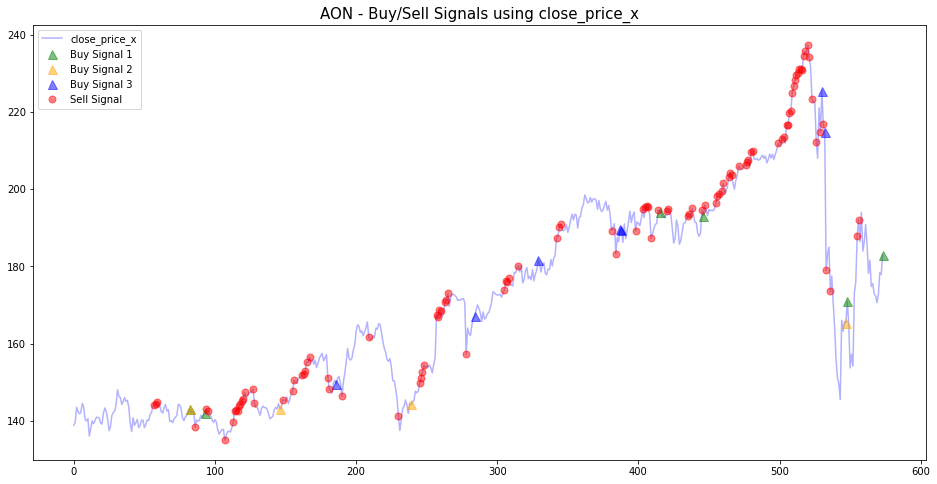

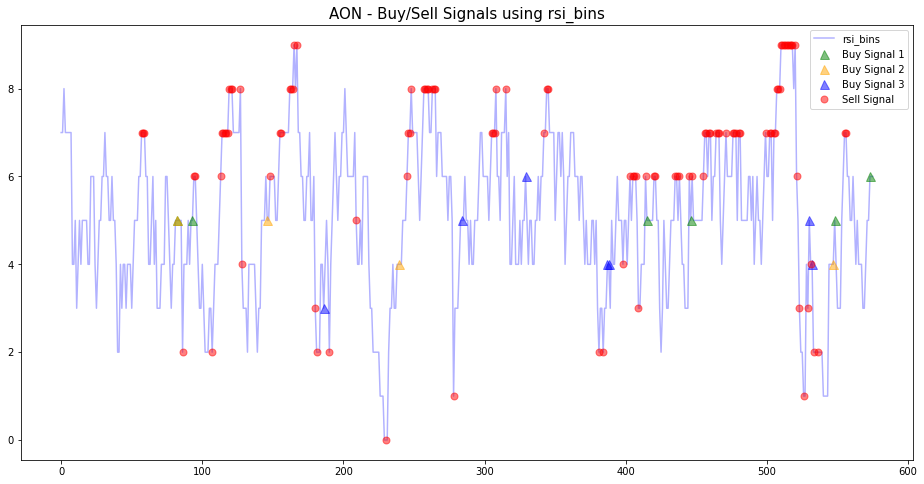

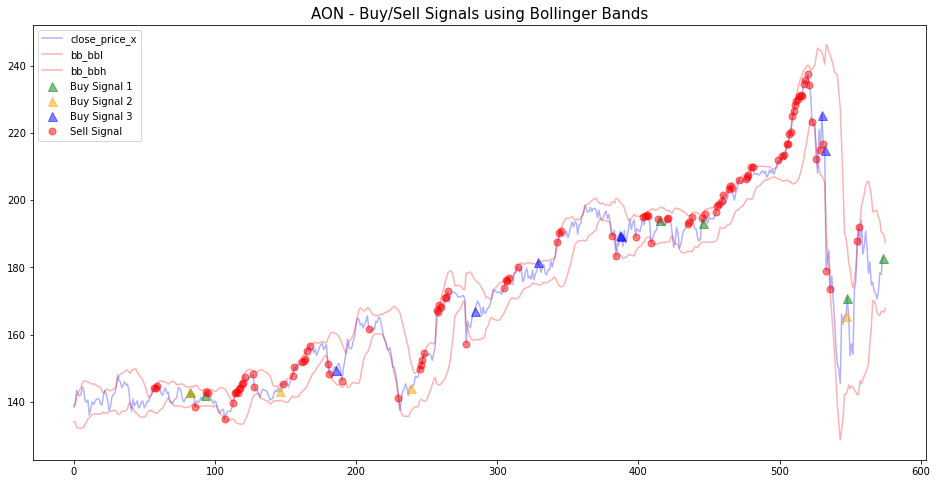

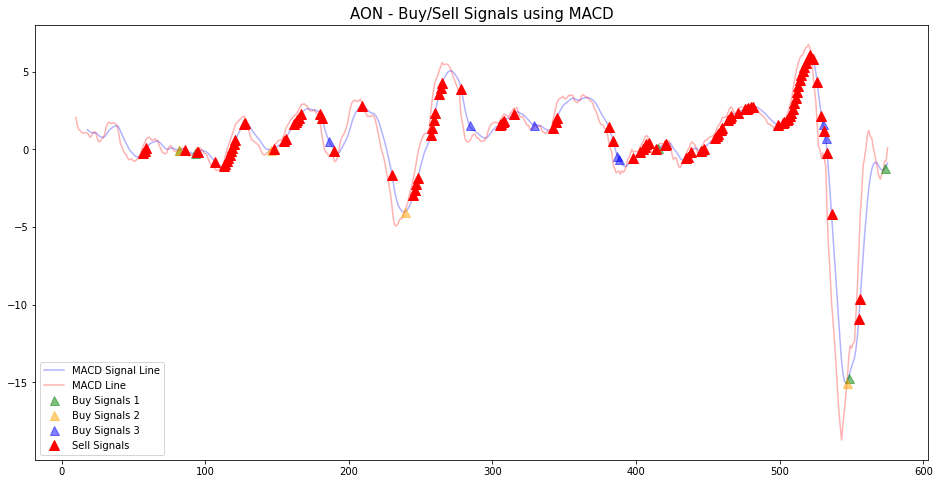

In [480]:
# Run Charts
your_symbol = 'AON'
create_charts_1(clean_data, your_symbol, include_sell=True)
create_charts_1(clean_data, your_symbol, 'rsi_bins')
create_charts_2(clean_data, your_symbol)
create_charts_3(clean_data, your_symbol)

## Backtest signals with exit strategies

In [514]:
def backtest(df, buy_signal_column, support_column, stop_loss, max_holding_days, max_drop, money_per_trade, max_invested):

    # Create buy group1 column and uuid
    df['buy_group_backtest'] = np.NaN
    df['uuid'] = df['fake_index'].astype(str) + df['symbol']

    # A new group will be assigned when
    df['buy_group_backtest'].mask(df[buy_signal_column] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['sell_signal?'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['low_price'] <= df[support_column], df['uuid'], inplace=True)

    # Forward fill groups
    df['buy_group_backtest'] = df['buy_group_backtest'].ffill()

    # Number of days holding 
    df['buy_group_backtest_holdings'] = df.groupby('buy_group_backtest')['timestamp'].rank(method='first')

    # Calculate group cumulative product
    df['buy_group_backtest_cum_return'] = df.groupby('buy_group_backtest').cumprod()['daily_return']
    
    # Create max drop limit
    df['buy_group_backtest_cum_return_shift'] = df['buy_group_backtest_cum_return'].shift(1)
    df['buy_group_backtest_cum_return_diff'] = df['buy_group_backtest_cum_return_shift'] - df['buy_group_backtest_cum_return']
    df['max_drop_limit'] = np.NaN
    df['max_drop_limit'].mask((df['buy_group_backtest_cum_return_diff'] >= max_drop) 
                              & (df['buy_group_backtest_holdings'] != 1), True, inplace=True)    
    
    # Create Loss Threshold
    df['loss_threshold'] = np.NaN
    df['loss_threshold'].mask(df['buy_group_backtest_cum_return'] <= stop_loss, True, inplace=True)

    # Number of days holding threshold
    df['holding_threshold'] = np.NaN
    df['holding_threshold'].mask(df['buy_group_backtest_holdings'] == max_holding_days, True, inplace=True)

    # Total Money Invested
    groups = set(df[df[buy_signal_column] == True]['buy_group_backtest'])
    df['initial_buy'] = np.NaN
    df['initial_buy'].mask(df['buy_group_backtest'].isin(groups), money_per_trade, inplace=True)
    df['today_value_of_investment'] = df['initial_buy'] * df['buy_group_backtest_cum_return']
    
    total_day = df.groupby('just_date').sum()['initial_buy'].reset_index()
    total_day.columns = ['just_date', 'daily_invested']
    df = pd.merge(df, total_day, on ='just_date', how='left')
    
    # Create buy group1 column and uuid
    df['buy_group_backtest'] = np.NaN
    df['uuid'] = df['fake_index'].astype(str) + df['symbol']

    # A new group will be assigned when
    df['buy_group_backtest'].mask((df[buy_signal_column] == True) & (df['daily_invested'] <= max_invested), df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['sell_signal?'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['low_price'] <= df[support_column], df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['holding_threshold'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['loss_threshold'] == True, df['uuid'], inplace=True)
    df['buy_group_backtest'].mask(df['max_drop_limit'] == True, df['uuid'], inplace=True)
    
    # Forward fill groups
    df['buy_group_backtest'] = df['buy_group_backtest'].ffill()

    # Number of days holding
    df['buy_group_backtest_holdings'] = df.groupby('buy_group_backtest')['timestamp'].rank(method='first')

    # Calculate group cumulative product
    df['buy_group_backtest_cum_return'] = df.groupby('buy_group_backtest').cumprod()['daily_return']

    # Identify groups
    buy_groups = set(df[(df[buy_signal_column] == True)]['buy_group_backtest'])
    
    # Get last row of every group
    g = df[df['buy_group_backtest'].isin(buy_groups)].groupby('buy_group_backtest')
    returns = pd.concat([g.tail(1)])[['timestamp','symbol', 'industry', 'buy_group_backtest_cum_return', 'buy_group_backtest_holdings']]
    
    return returns, df

In [515]:
def money_maker(data_frame, signal_name, returns, money_per_trade, print_which='all'):
    
    # Create list of Buy Groups
    buy_groups = set(data_frame[data_frame[signal_name] == True]['buy_group_backtest'])
    plot_me = data_frame[data_frame['buy_group_backtest'].isin(buy_groups)]
    plot_me['money_invested'] = (plot_me['buy_group_backtest_cum_return'] * money_per_trade)
    plot_me['money_return'] = plot_me['money_invested'] - money_per_trade
    
    print(signal_name)
    
    if print_which in ('all', '1'):
        # Money Invested
        plot_me.groupby('timestamp').sum()['money_invested'].plot(figsize=(14,6), color='blue', alpha=0.5, title='Money Invested')
        plt.show();
    
        # Money Gains daily
        plot_me.groupby('timestamp').sum()['money_return'].plot(figsize=(14,6), color='blue', alpha=0.5, title='Gains per Trade', label='Gains per Trade')

    # Cum sum of gains
    returns['money_back'] = (returns['return'] * money_per_trade) - money_per_trade
    gains_df = returns.groupby('date').sum()['money_back'].reset_index()
    gains_df['cum_sum'] = gains_df['money_back'].cumsum()
    gains_df.set_index('date', inplace=True)

    if print_which in ('all', '2'):
        gains_df['cum_sum'].plot(figsize=(14,6), color='green', alpha=0.5, title='Gains - Per Trade and Cum Sum', label = 'Cum Sum of Gains')
        plt.legend()
        plt.show()
    
    # Number of trades
    no_trades = data_frame[(data_frame[signal_name] == True) & (data_frame['buy_group_backtest'].isin(buy_groups))]

    if print_which in ('all', '2'):
        no_trades.groupby('just_date').count()['buy_group_backtest'].plot(figsize=(14,6), color='blue', alpha=0.5, title='Number of Trades per Day', label = 'Daily Trades')

    # Number of trades - Sum sum
    cumsum_trades = data_frame[(data_frame[signal_name] == True) & (data_frame['buy_group_backtest'].isin(buy_groups))]
    cumsum_trades = cumsum_trades.groupby('timestamp').count()['buy_group_backtest'].reset_index()
    cumsum_trades['cum_sum'] = cumsum_trades['buy_group_backtest'].cumsum()
    cumsum_trades.set_index('timestamp', inplace=True)

    if print_which in ('all', '3'):
        cumsum_trades['cum_sum'].plot(figsize=(14,6), color='green', alpha=0.5, title='Number of Trades - Daily and Cum Sum', label='Cum Sum of Trades')
        plt.legend()
        plt.show();
    
    if print_which in ('all', '4'):
        # Number of trades - Sum sum
        gain_trade = gains_df['cum_sum'] / cumsum_trades['cum_sum']
        gain_trade.plot(figsize=(14,6), color='green', alpha=0.5, title='Ratio of Cum Sum Gain / Cum Sum Trades',)
        plt.show();

### Backtest signal 1

,count,mean,std,min,25%,50%,75%,max
days,,,,,,,,
1.0,1489.0,0.998755,0.033199,0.720930,0.979592,1.000164,1.014634,1.166667
2.0,772.0,1.015542,0.032060,0.980080,0.994921,1.005650,1.027709,1.290713
3.0,662.0,1.031849,0.055601,0.973737,1.000000,1.014402,1.042854,1.553846
4.0,602.0,1.051154,0.076446,0.972477,1.004795,1.025210,1.064581,1.608974
5.0,514.0,1.053023,0.072707,0.966055,1.006060,1.030765,1.070578,1.549392
6.0,452.0,1.058259,0.084273,0.942211,1.003911,1.032474,1.077912,1.510452
7.0,407.0,1.067421,0.084549,0.974468,1.009644,1.037098,1.092155,1.507538
8.0,306.0,1.057923,0.076640,0.950480,1.006965,1.036091,1.077231,1.493464
9.0,235.0,1.057040,0.082302,0.929249,1.005515,1.037669,1.071525,1.606667


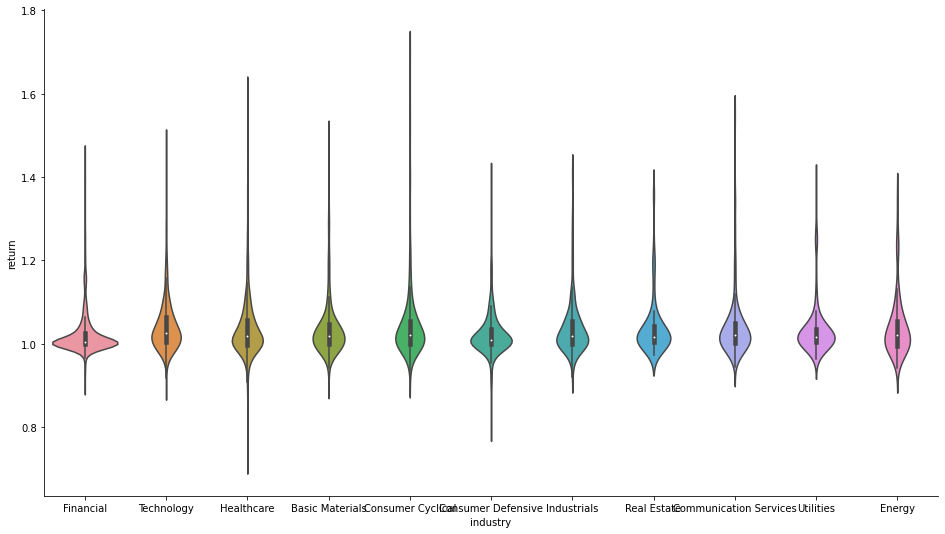

In [518]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?1', 'low_min_d10', 0.98, 30, 0.05, 100, 5000)
returns.columns = ['date','symbol', 'industry', 'return', 'days']
g = sns.catplot(x="industry", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
returns.groupby('days').describe()['return']

buy_signal?1


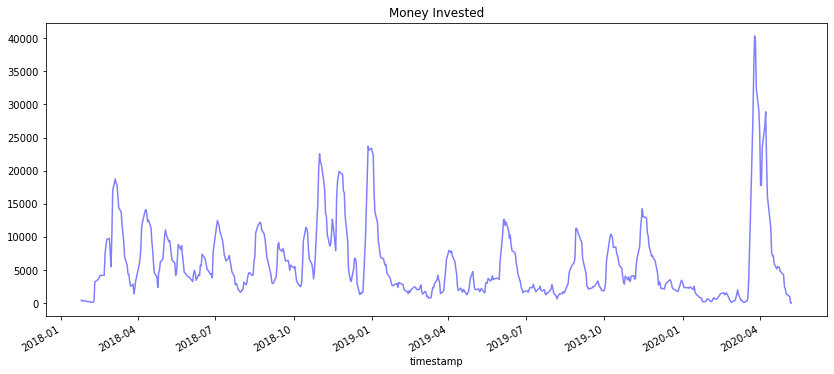

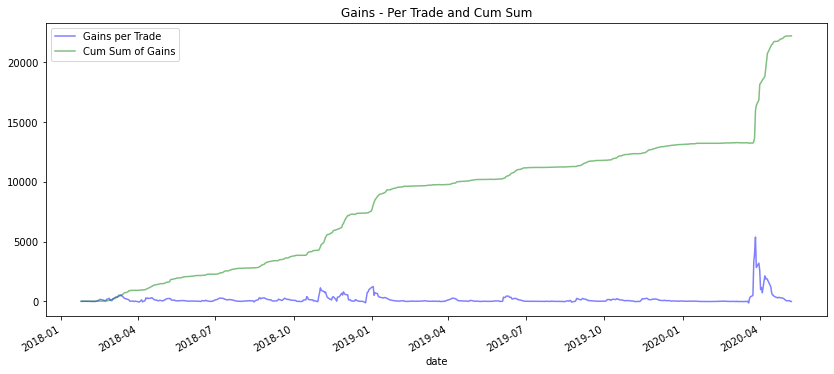

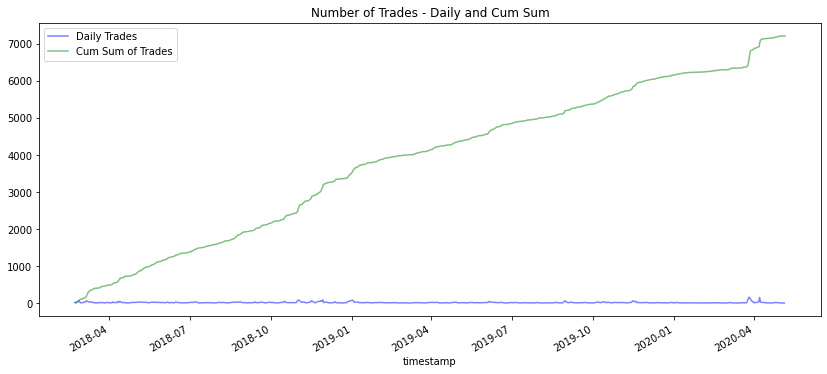

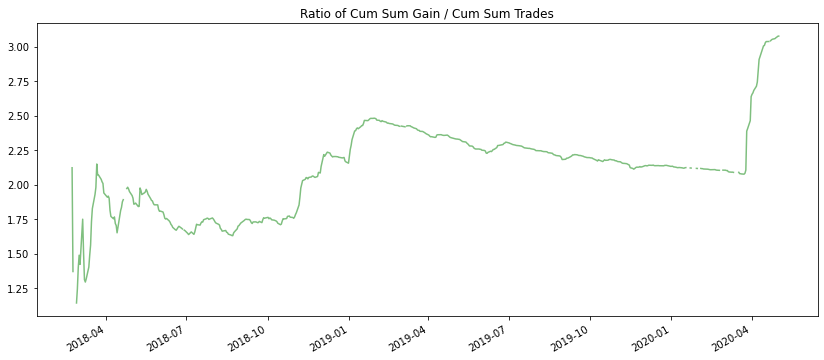

In [519]:
money_maker(data_frame, 'buy_signal?1', returns, 100)

In [468]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns, data_frame = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?1', 'low_min_d30', tolerance, 30, max_drop, 100, 5000)
        returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

AttributeError: 'tuple' object has no attribute 'columns'

### Backtest signal 2

,count,mean,std,min,25%,50%,75%,max
industry,,,,,,,,
Basic Materials,221.0,1.027685,0.071871,0.864769,0.989293,1.008255,1.035874,1.431235
Communication Services,145.0,1.045513,0.076251,0.958176,0.996295,1.020915,1.056186,1.351499
Consumer Cyclical,245.0,1.041155,0.088420,0.772167,0.995138,1.016097,1.051475,1.553846
Consumer Defensive,163.0,1.028293,0.064784,0.700000,0.997244,1.011171,1.037426,1.398533
Energy,63.0,1.059384,0.108949,0.972656,1.000000,1.017341,1.080382,1.658052
Financial,897.0,1.022726,0.052869,0.928948,1.000000,1.002975,1.023906,1.593361
Healthcare,1100.0,1.034346,0.069652,0.834206,0.995988,1.016219,1.054486,1.545620
Industrials,270.0,1.035048,0.072379,0.924619,0.997187,1.017871,1.046501,1.626311
Real Estate,89.0,1.036139,0.074897,0.980408,0.998695,1.012705,1.033842,1.403146


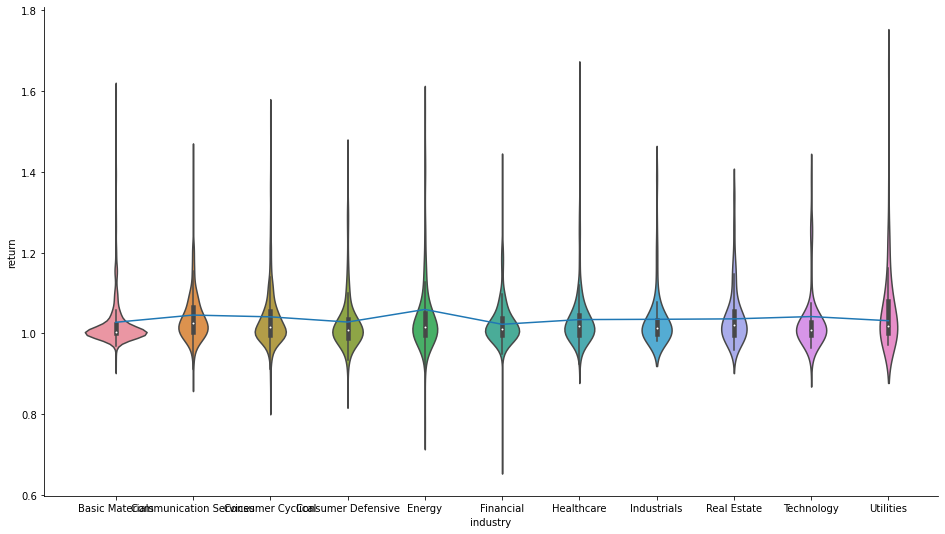

In [520]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?2', 'low_min_d10',0.98, 30, 0.05, 100, 5000)
returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
g = sns.catplot(x="industry", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
h = returns.groupby('industry').mean()['return'].plot()
returns.groupby('industry').describe()['return']

buy_signal?2


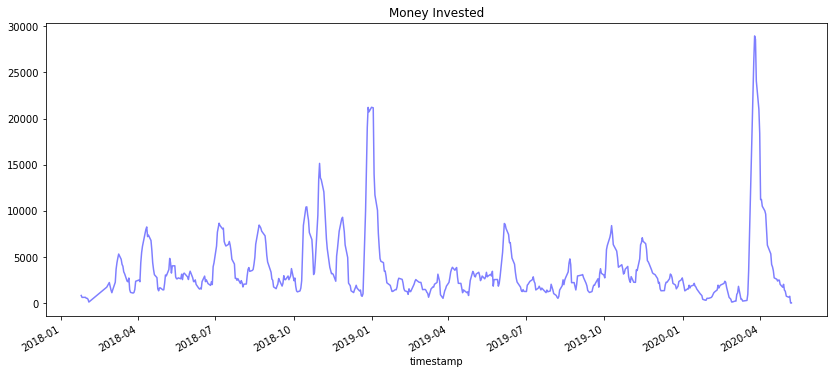

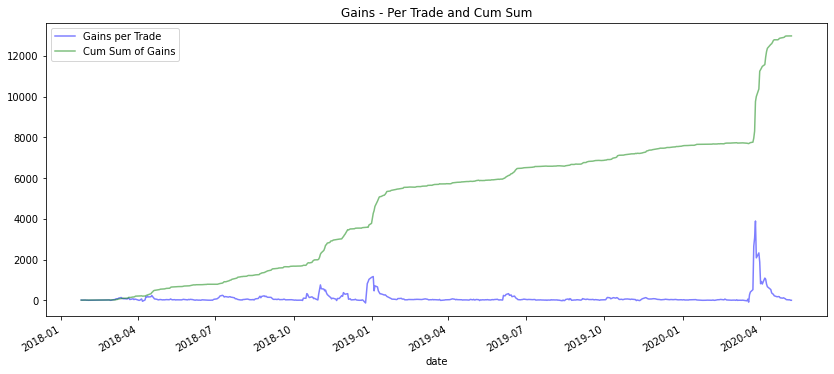

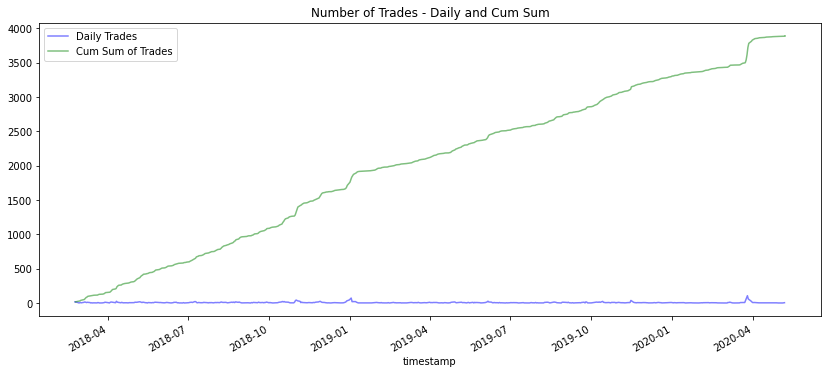

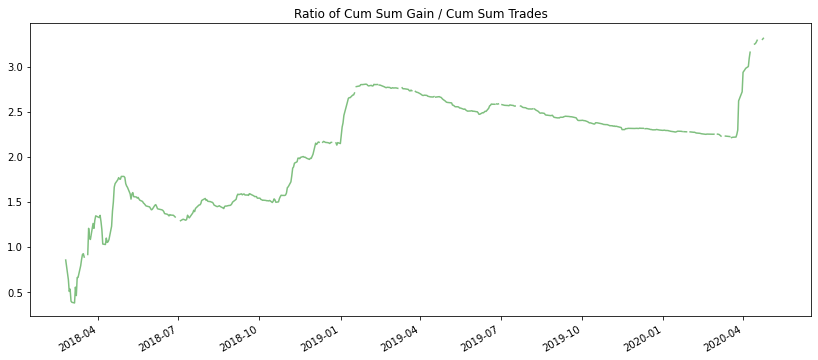

In [521]:
money_maker(data_frame, 'buy_signal?2', returns, 100)

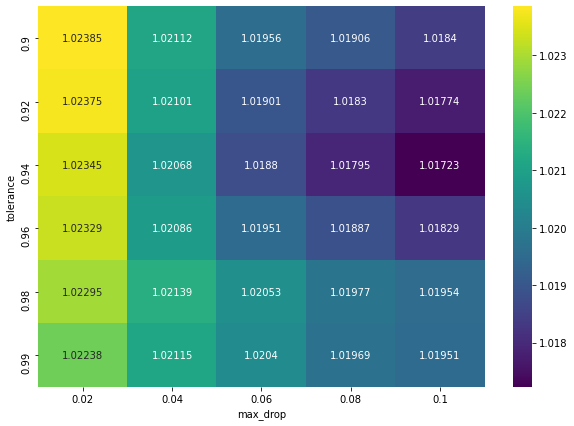

In [795]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?2', 'low_min_d30', tolerance, 30, max_drop)
        returns.columns = ['symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

### Backtest signal 3

,count,mean,std,min,25%,50%,75%,max
industry,,,,,,,,
Basic Materials,330.0,1.032985,0.076684,0.762411,0.997586,1.027033,1.058895,1.431235
Communication Services,201.0,1.054998,0.092385,0.909091,1.008421,1.038782,1.066026,1.549392
Consumer Cyclical,315.0,1.043998,0.082542,0.906137,0.997045,1.021116,1.060066,1.576859
Consumer Defensive,230.0,1.030461,0.062550,0.737589,1.001391,1.016789,1.045502,1.445989
Energy,66.0,1.021410,0.059202,0.906788,0.985161,1.013157,1.045970,1.203704
Financial,1205.0,1.026519,0.059891,0.753259,1.001233,1.010078,1.035494,2.133886
Healthcare,1308.0,1.057010,0.103366,0.759259,1.000751,1.032974,1.078420,1.848739
Industrials,410.0,1.033330,0.066013,0.816901,0.999139,1.018373,1.048678,1.418824
Real Estate,212.0,1.037722,0.054286,0.931049,1.010871,1.026820,1.046026,1.317141


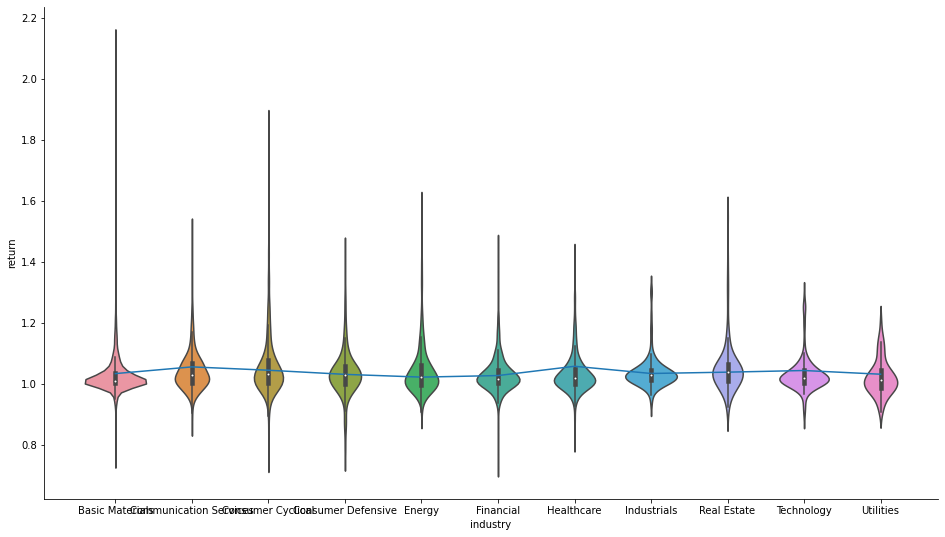

In [522]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?3', 'low_min_d10',0.98, 30, 0.05, 100, 5000)
returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
g = sns.catplot(x="industry", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
h = returns.groupby('industry').mean()['return'].plot()
returns.groupby('industry').describe()['return']

buy_signal?3


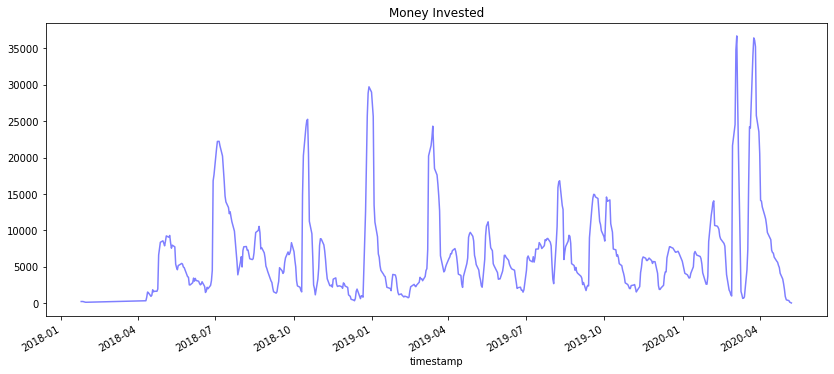

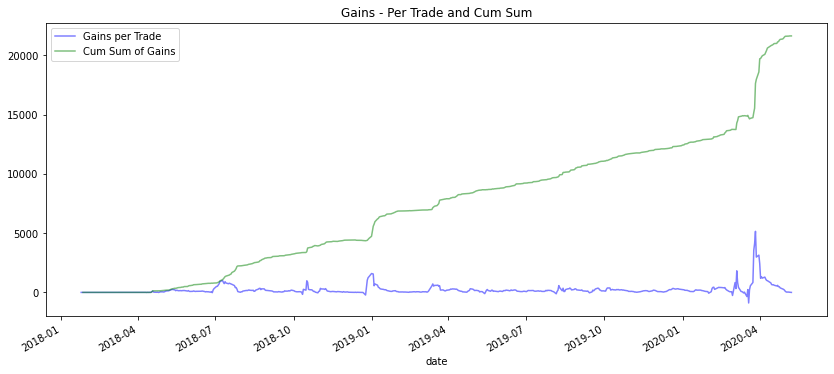

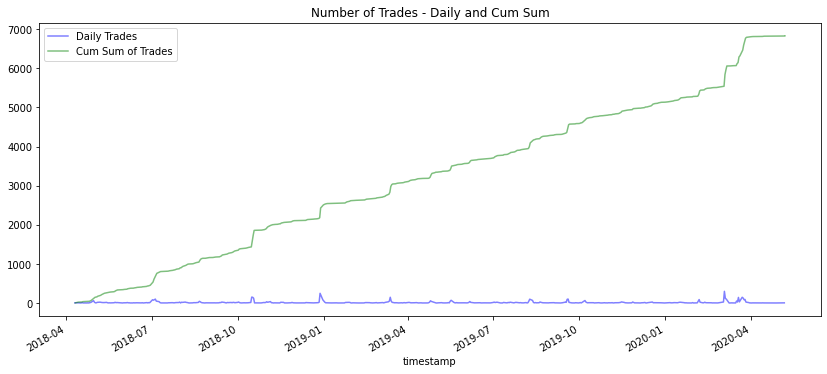

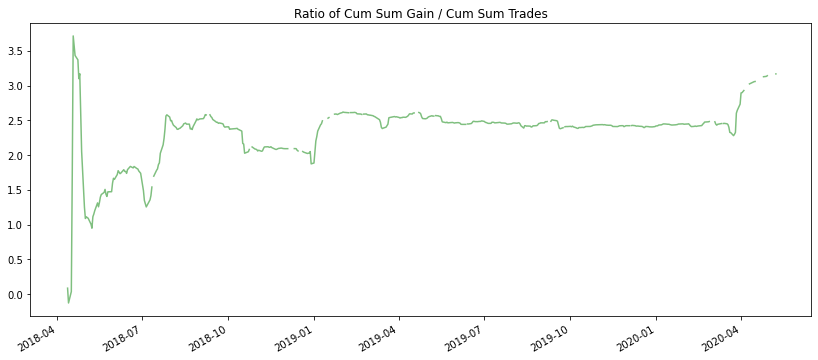

In [523]:
money_maker(data_frame, 'buy_signal?3', returns, 100)

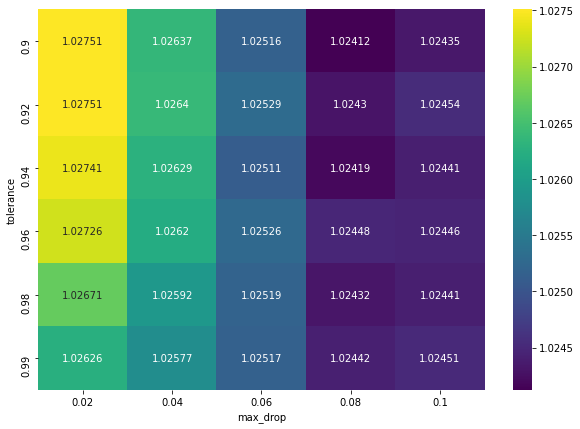

In [796]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns, data_frame = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?3', 'low_min_d30', tolerance, 30, max_drop)
        returns.columns = ['symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

### Backtest signal 4

,count,mean,std,min,25%,50%,75%,max
days,,,,,,,,
1.0,2880.0,1.019296,0.058907,0.768116,1.000000,1.011932,1.030896,2.164502
2.0,898.0,1.015665,0.054384,0.606667,0.991136,1.003894,1.024320,1.514286
3.0,828.0,1.025610,0.070644,0.843137,0.991407,1.009673,1.036074,1.553846
4.0,702.0,1.055420,0.097457,0.884285,1.000965,1.022851,1.072873,1.747423
5.0,626.0,1.061709,0.101445,0.848039,1.004526,1.035088,1.077730,2.089936
6.0,644.0,1.062109,0.085993,0.896659,1.008755,1.037647,1.081672,1.584031
7.0,607.0,1.068086,0.101608,0.923763,1.011876,1.036660,1.093504,2.133886
8.0,620.0,1.055441,0.068255,0.915028,1.011246,1.038141,1.078032,1.434608
9.0,551.0,1.063706,0.087433,0.966667,1.012440,1.038704,1.077104,1.748014


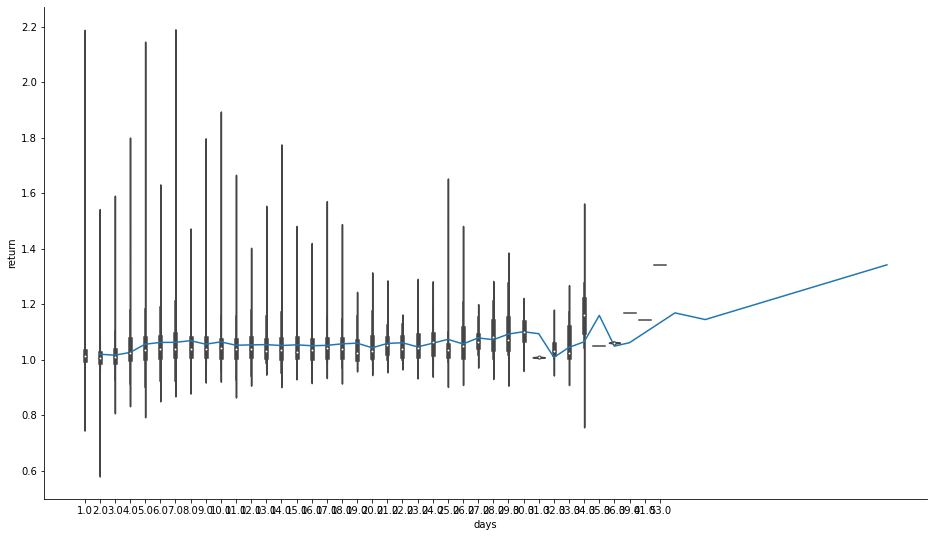

In [524]:
returns, data_frame = backtest(clean_data[clean_data['year'] > 2017], 'buy_signal?4', 'low_min_d10',0.98, 30, 0.05, 100, 5000)
returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
g = sns.catplot(x="days", y="return", kind="violin", data=returns)
g.fig.set_size_inches(15,8);
h = returns.groupby('days').mean()['return'].plot()
returns.groupby('days').describe()['return']

buy_signal?4


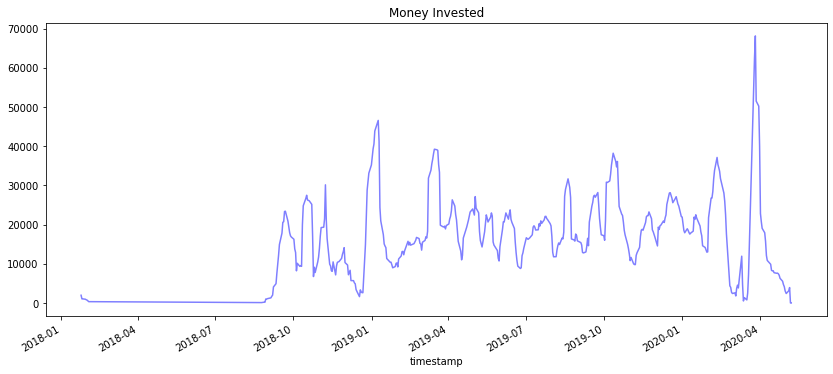

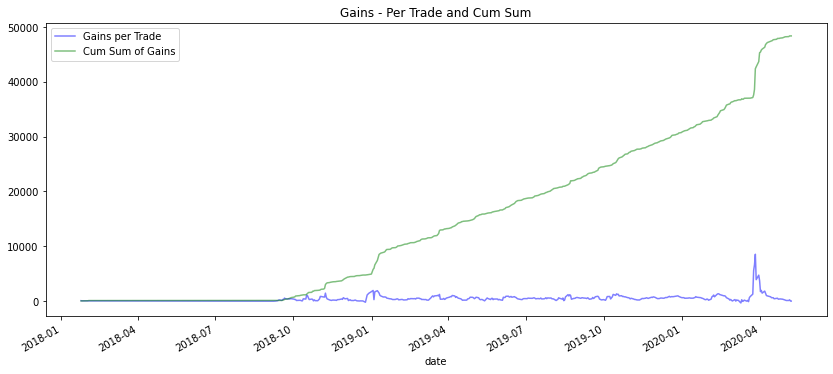

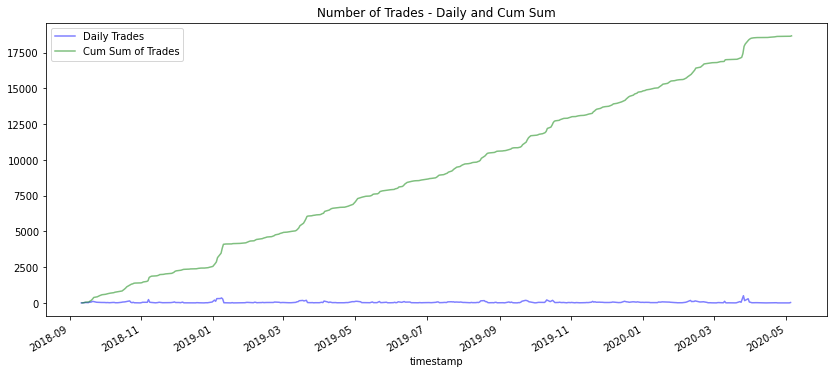

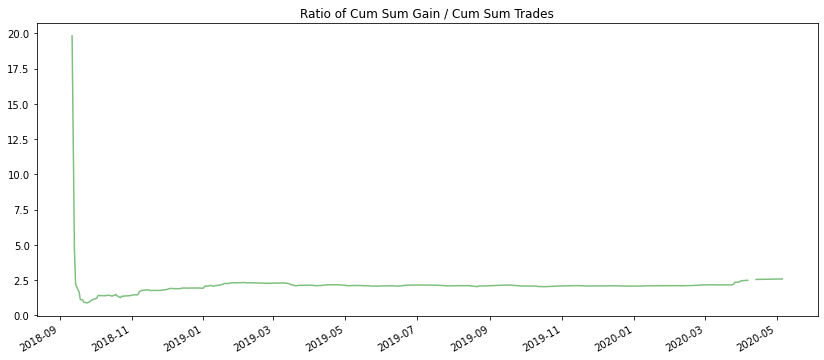

In [525]:
money_maker(data_frame, 'buy_signal?4', returns, 100)

In [471]:
# Plot Close Price
colors = ['blue', 'green', 'red', 'orange', 'black', 'pink']
heatmap = []
for idx, tolerance in enumerate([0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    for max_drop in [0.02, 0.04, 0.06, 0.08, 0.1]:
        returns, data_frame = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?4', 'low_min_d30', tolerance, 30, max_drop,100,5000)
        returns.columns = ['date', 'symbol', 'industry', 'return', 'days']
        heatmap.append([tolerance, max_drop, returns['return'].mean()])
        
to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
plt.subplots(figsize=(10,7))
sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
plt.show()

KeyboardInterrupt: 

buy_signal?1


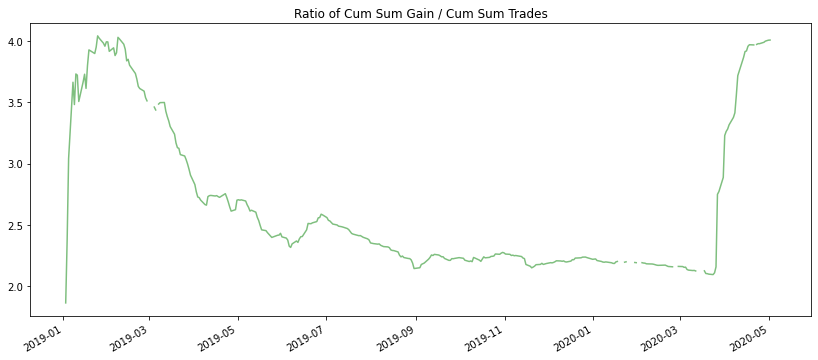

buy_signal?2


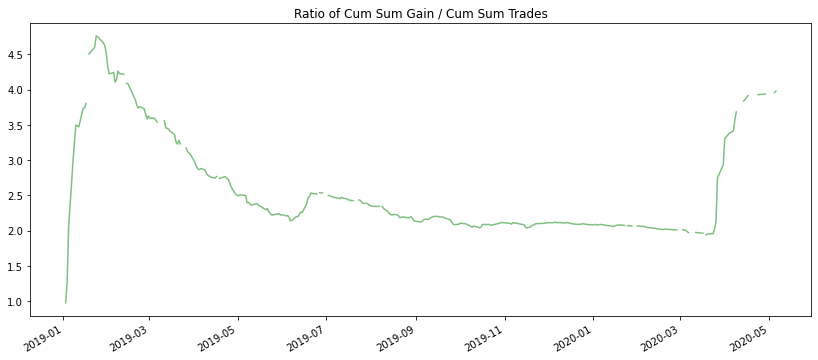

buy_signal?3


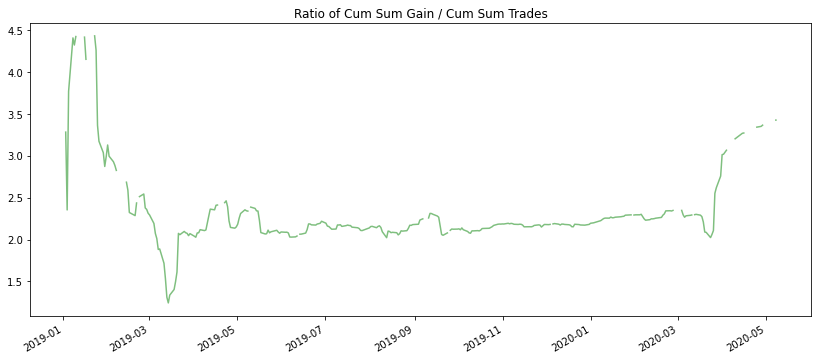

buy_signal?4


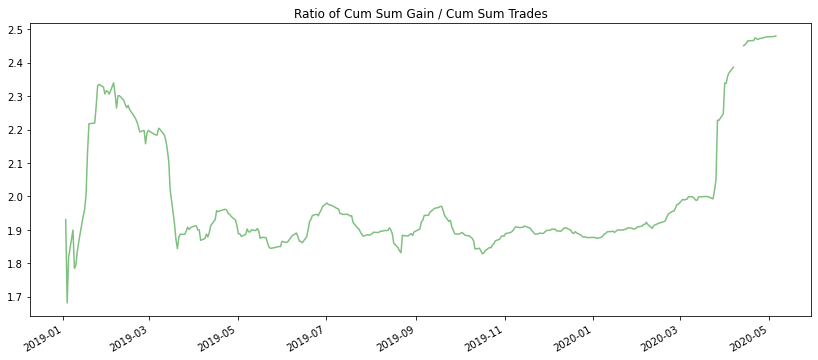

In [453]:


returns1, data_frame1 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?1', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns1.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame1, 'buy_signal?1', returns1, 100, '4')

returns2, data_frame2 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?2', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns2.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame2, 'buy_signal?2', returns2, 100, '4')

returns3, data_frame3 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?3', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns3.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame3, 'buy_signal?3', returns3, 100, '4')

returns4, data_frame4 = backtest(clean_data[clean_data['year'] > 2018], 'buy_signal?4', 'low_min_d30',0.98, 30, 0.05, 100, 5000)
returns4.columns = ['date', 'symbol', 'industry', 'return', 'days']
money_maker(data_frame4, 'buy_signal?4', returns4, 100, '4')

buy_signal?1


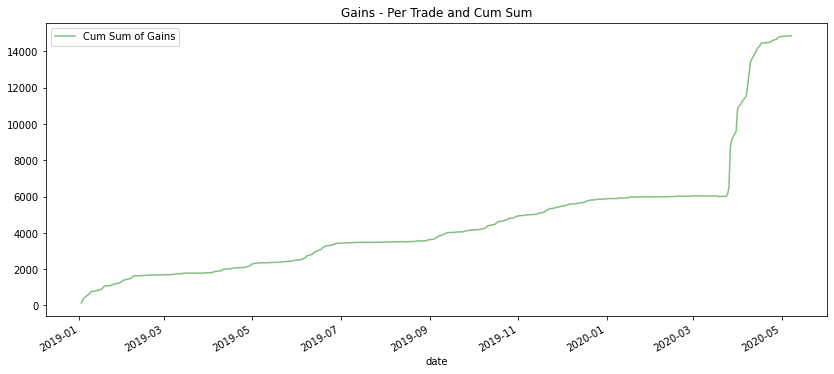

buy_signal?2


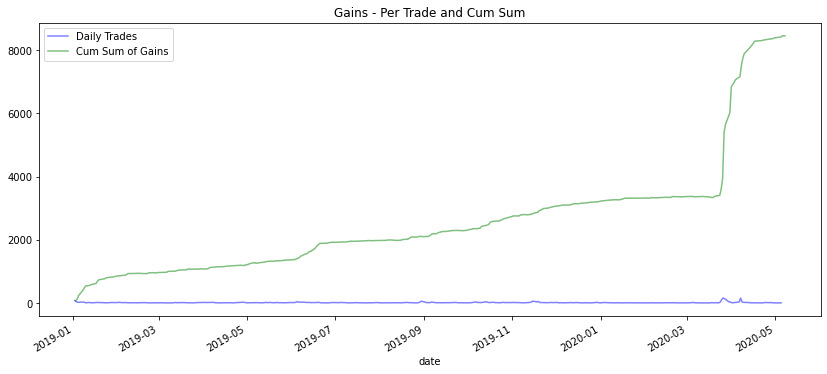

buy_signal?3


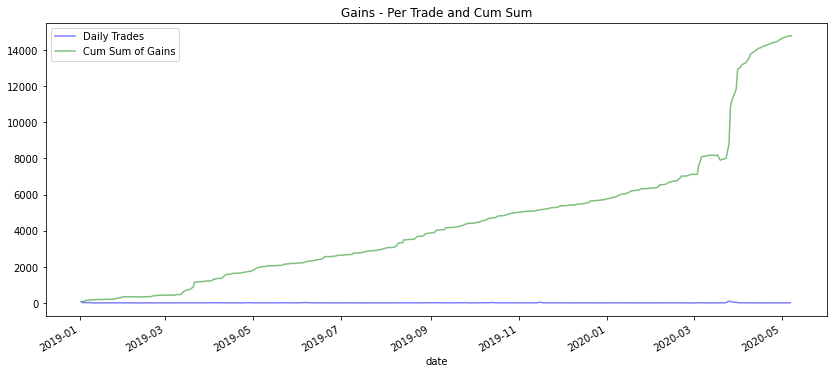

buy_signal?4


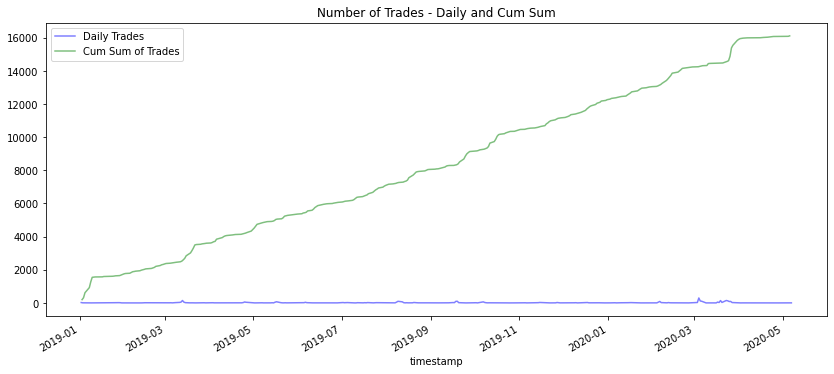

In [466]:
money_maker(data_frame1, 'buy_signal?1', returns1, 100, '2')
money_maker(data_frame2, 'buy_signal?2', returns2, 100, '2')
money_maker(data_frame3, 'buy_signal?3', returns3, 100, '2')
money_maker(data_frame4, 'buy_signal?4', returns4, 100, '2')

In [481]:
clean_data.head()

,index,timestamp,high_price,low_price,open_price,close_price_x,volume,symbol,name,industry,interval,just_date,low_is_min_7,low_is_min_14,close_price_shift,high_previous,low_previous,close_previous,open_previous,low_min_d5,low_min_d5_shift1_5,low_min_d5_shift2_10,high_max_d5,high_max_d5_shif1_5,high_max_d5_shif2_10,close_min_d5,open_min_d5,close_max_d5,open_max_d5,low_min_d10,low_min_d10_shift1_10,low_min_d10_shift2_20,high_max_d10,high_max_d10_shif1_10,high_max_d10_shif2_20,close_min_d10,open_min_d10,close_max_d10,open_max_d10,low_min_d15,low_min_d15_shift1_15,low_min_d15_shift2_30,high_max_d15,high_max_d15_shif1_15,high_max_d15_shif2_30,close_min_d15,open_min_d15,close_max_d15,open_max_d15,low_min_d20,low_min_d20_shift1_20,low_min_d20_shift2_40,high_max_d20,high_max_d20_shif1_20,high_max_d20_shif2_40,close_min_d20,open_min_d20,close_max_d20,open_max_d20,low_min_d25,low_min_d25_shift1_25,low_min_d25_shift2_50,high_max_d25,high_max_d25_shif1_25,high_max_d25_shif2_50,close_min_d25,open_min_d25,close_max_d25,open_max_d25,low_min_d30,low_min_d30_shift1_30,low_min_d30_shift2_60,high_max_d30,high_max_d30_shif1_30,high_max_d30_shif2_60,close_min_d30,open_min_d30,close_max_d30,open_max_d30,low_min_d60,low_min_d60_shift1_60,low_min_d60_shift2_120,high_max_d60,high_max_d60_shif1_60,high_max_d60_shif2_120,close_min_d60,open_min_d60,close_max_d60,open_max_d60,low_min_d90,low_min_d90_shift1_90,low_min_d90_shift2_180,high_max_d90,high_max_d90_shif1_90,high_max_d90_shif2_180,close_min_d90,open_min_d90,close_max_d90,open_max_d90,low_min_d120,low_min_d120_shift1_120,low_min_d120_shift2_240,high_max_d120,high_max_d120_shif1_120,high_max_d120_shif2_240,close_min_d120,open_min_d120,close_max_d120,open_max_d120,year,daily_return,moving_1d_return,moving_2d_return,moving_3d_return,moving_5d_return,moving_7d_return,moving_30d_return_mean,moving_30d_return_std,moving_60d_return_mean,moving_60d_return_std,moving_90d_return_mean,moving_90d_return_std,moving_30d_min_return,moving_60d_min_return,moving_90d_min_return,sma_10d,sma_10d_shift,sma_10d_coef,sma_10d_std,stationary_sma_10d,stationary_sma_10d_zscore,stationary_sma_10d_zscore_shift,stationary_sma_10d_zscore_shift_2,stationary_sma_10d_zscore_min,stationary_sma_10d_zscore_max,stationary_sma_10d_zscore_min_shift_1,stationary_sma_10d_zscore_min_shift_2,stationary_sma_10d_zscore_min_shift_3,stationary_sma_10d_zscore_min_all,stationary_sma_10d_zscore_min_all_shift,stationary_sma_10d_zscore_min_all_shift_2,sma_20d,sma_20d_shift,sma_20d_coef,sma_20d_std,stationary_sma_20d,stationary_sma_20d_zscore,stationary_sma_20d_zscore_shift,stationary_sma_20d_zscore_shift_2,stationary_sma_20d_zscore_min,stationary_sma_20d_zscore_max,stationary_sma_20d_zscore_min_shift_1,stationary_sma_20d_zscore_min_shift_2,stationary_sma_20d_zscore_min_shift_3,stationary_sma_20d_zscore_min_all,stationary_sma_20d_zscore_min_all_shift,stationary_sma_20d_zscore_min_all_shift_2,sma_100d,sma_100d_shift,sma_100d_std,stationary_sma_100d,stationary_sma_100d_shift,stationary_sma_100d_zscore,stationary_sma_100d_zscore_min,stationary_sma_100d_zscore_max,stationary_sma_100d_zscore_min_shift_1,stationary_sma_100d_zscore_min_shift_2,stationary_sma_100d_zscore_min_shift_3,stationary_sma_100d_zscore_min_all,sma_200d,sma_200d_shift,sma_200d_std,stationary_sma_200d,stationary_sma_200d_shift,stationary_sma_200d_zscore,stationary_sma_200d_zscore_min,stationary_sma_200d_zscore_min_shift_1,stationary_sma_200d_zscore_min_shift_2,stationary_sma_200d_zscore_min_shift_3,stationary_sma_200d_zscore_min_all,momentum_rsi,momentum_rsi_low,momentum_rsi_high,rsi_bins,rsi_bins_low,rsi_bins_high,rsi_bins_shift_1d,rsi_bins_shift_2d,rsi_bins_shift_3d,rsi_bins_shift_1d_low,rsi_bins_shift_2d_low,rsi_bins_shift_3d_low,rsi_bins_shift_1d_high,rsi_bins_shift_2d_high,rsi_bins_shift_3d_high,rsi_7,rsi_14,rsi_21,rsi_28,rsi_35,rsi_70,rsi_105,rsi_140,rsi_175,rsi_210,rsi_std_35,rsi_std_70,rsi_std_140,rsi_avg_35,rsi_avg_70,rsi_avg_140,rsi_35_min_bin,rsi_70_min_bin,rsi_105_min_bin,rsi

In [822]:
def compare_years(max_drop_list, tolerance_list, years_list, signal_name, your_df):
    
    for idxx, year in enumerate(years_list):
        print(year)
        heatmap = []
        for idx, tolerance in enumerate(tolerance_list):
            for max_drop in max_drop_list: 
                returns = backtest(your_df[your_df['year'] == year], signal_name, 'low_min_d30', tolerance, 30, max_drop)
                returns.columns = ['symbol', 'industry', 'return', 'days']
                heatmap.append([tolerance, max_drop, returns['return'].mean()])
        to_plot = pd.DataFrame(heatmap, columns=['tolerance', 'max_drop', 'return'])
        pivot = to_plot.pivot(index='tolerance', columns='max_drop', values='return')
        sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')
    
        plt.show()

2017


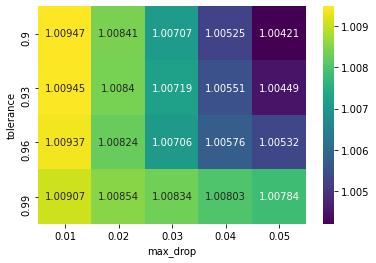

2018


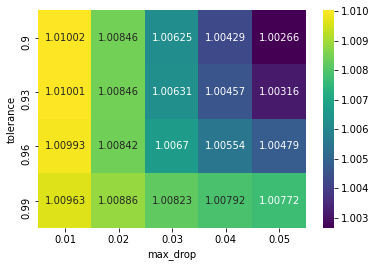

2019


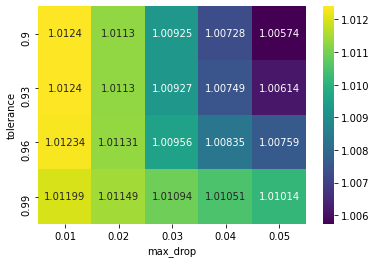

2020


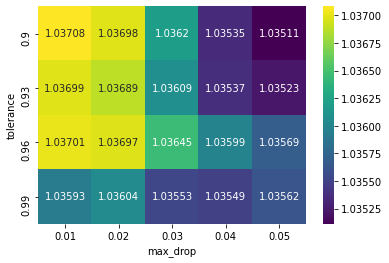

In [826]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?1',
              your_df=clean_data)

2017


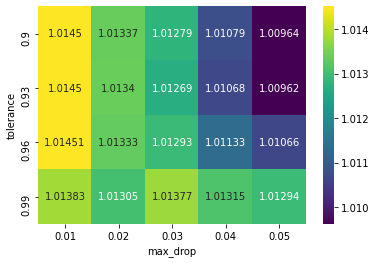

2018


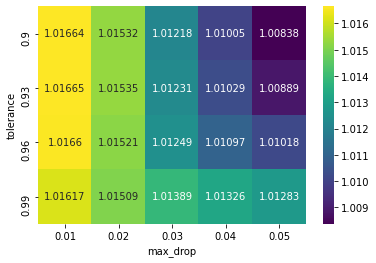

2019


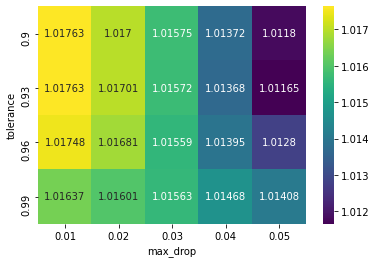

2020


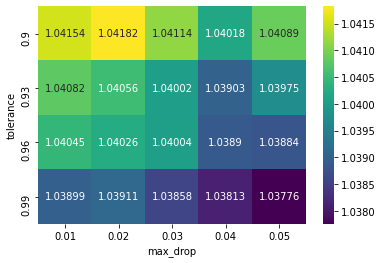

In [827]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?2',
              your_df=clean_data)

2017


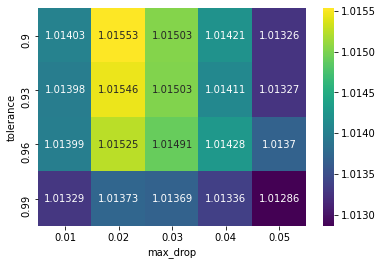

2018


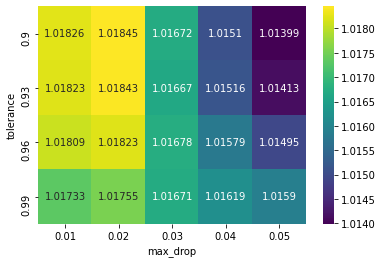

2019


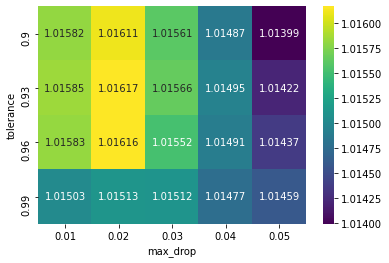

2020


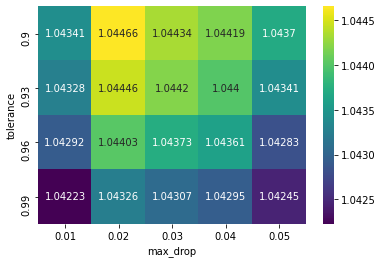

In [825]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?3',
              your_df=clean_data)

2017


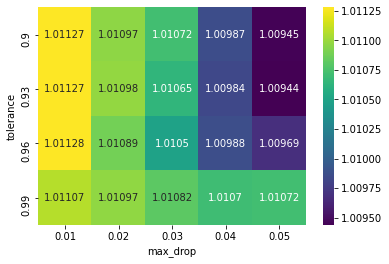

2018


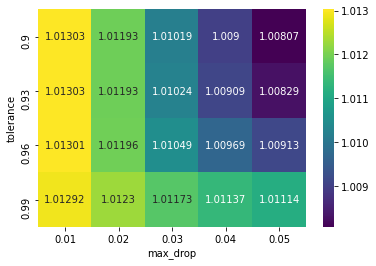

2019


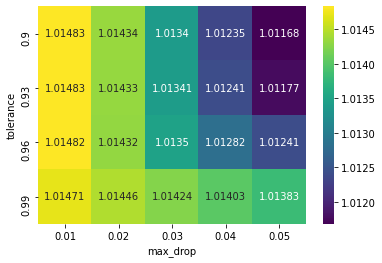

2020


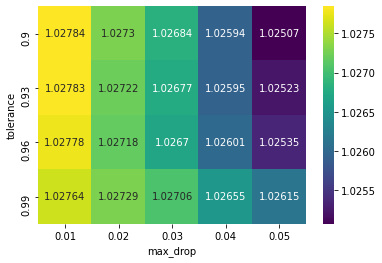

In [828]:
compare_years(max_drop_list=[0.01, 0.02, 0.03, 0.04, 0.05],
              tolerance_list=[0.9, 0.93, 0.96, 0.99],
              years_list=[2017, 2018, 2019, 2020],
              signal_name='buy_signal?4',
              your_df=clean_data)

In [65]:
to_plot = clean_data[(clean_data['buy_signal?1'] == True)]
to_plot['next_21d_return'].mean()

1.027172813878549

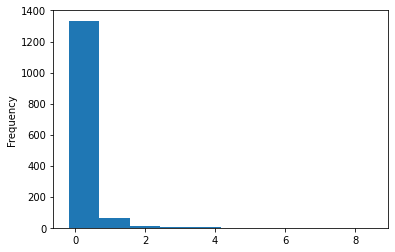

In [60]:
to_plot['macd_hist_3d_min_coef'].plot.hist()

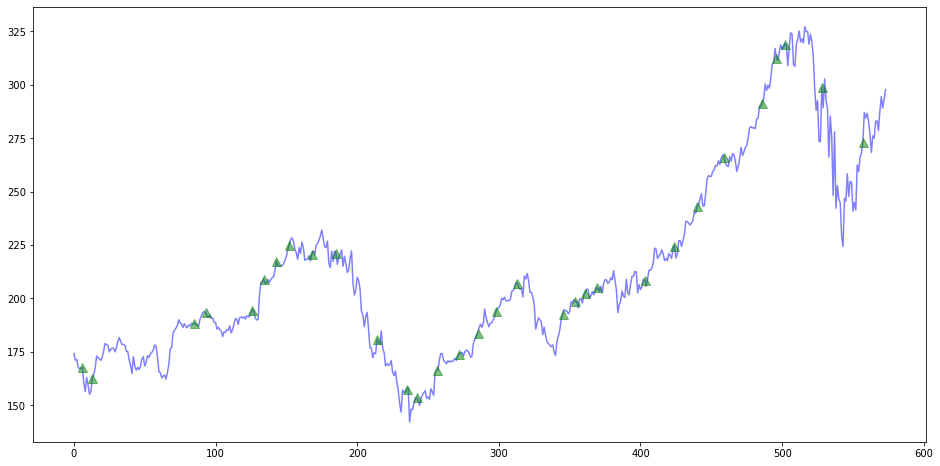

In [127]:
test = clean_data[clean_data['symbol'] == 'AAPL']
test['buy_reno'] = np.NaN
test['buy_reno'].mask(
                                        (
                                            #(test['stationary_sma_10d_zscore_shift_2'] <= test['stationary_sma_10d_zscore_shift'])
                                            #(test['stationary_sma_10d_zscore'] > test['stationary_sma_10d_zscore_shift'])
                                            #(test['stationary_sma_10d_zscore'] < test['stationary_sma_10d_zscore_max'])
                                            (test['stationary_sma_10d_zscore_shift'] == test['stationary_sma_10d_zscore_min'])
                                            #(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
                                            #& (df_2['stationary_sma_10d_zscore_shift_2'] <= (0.8 * df_2['stationary_sma_10d_zscore_min_all_shift_2']))
                                            & (test['moving_2d_return'] > 1)
                                            #& (test['rsi_bins'] < test['rsi_175_max_bin'])
                                            #& (test['rsi_bins'] > test['rsi_175_min_bin'])
                                            #& (test['macd_hist'] >= test['macd_hist_1d_shift'])
                                        )
                                        , True, inplace=True)

test['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.5)
test[test['buy_reno'] == True]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
#test['stationary_sma_10d_zscore'].plot(figsize=(16,8), color='blue', alpha=0.5)
#test['stationary_sma_10d_zscore_shift'].plot(figsize=(16,8), color='red', alpha=0.5)
#test['sma_20d'].plot(figsize=(16,8), color='red', alpha=0.5)

In [92]:
print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    #& (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_21d_return'] > 1)].count()['index'])

print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
   # & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_21d_return'] < 1)].count()['index'])


20
5


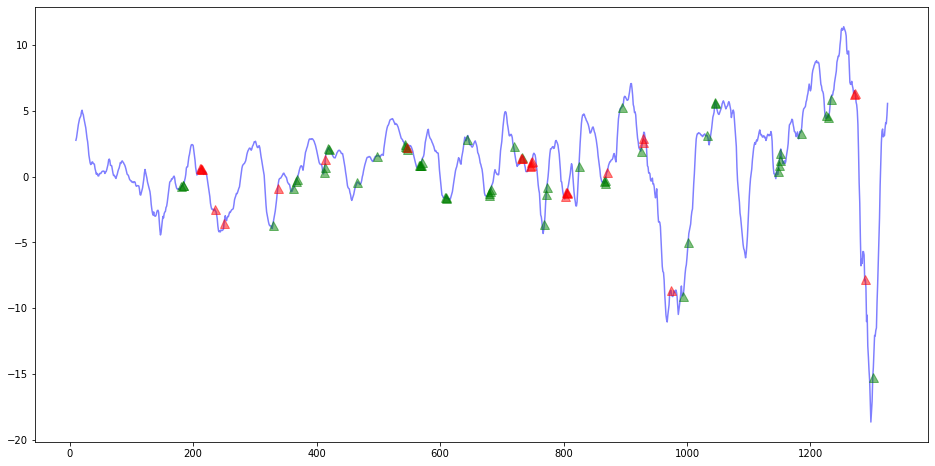

In [547]:
test['macd_line'].plot(figsize=(16,8), color='blue', alpha=0.5)

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    #& (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] > 1)]['macd_line'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
   # & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] < 1)]['macd_line'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')


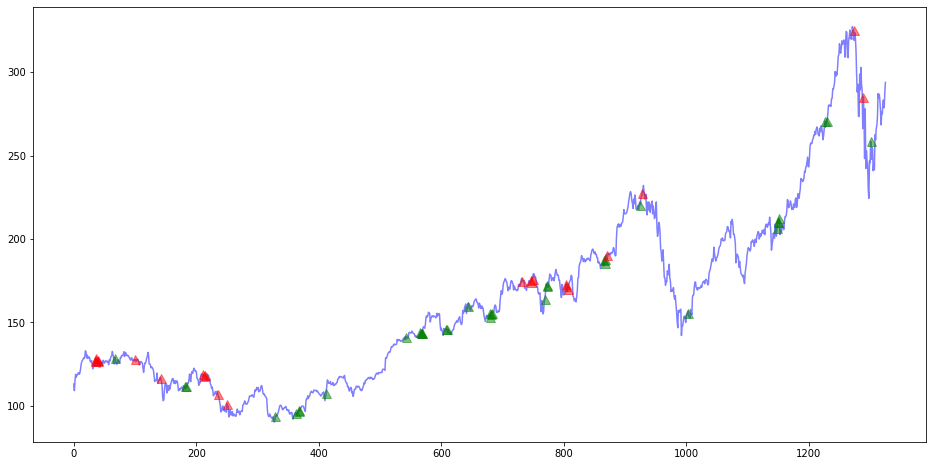

In [539]:
test['close_price_x'].plot(figsize=(16,8), color='blue', alpha=0.5)
#test['sma_10d'].plot(figsize=(16,8), color='green', alpha=0.5)
#test['sma_20d'].plot(figsize=(16,8), color='red', alpha=0.5)
#test[(test['low_min_d10'] > test['low_min_d10_shift1_10']) 
    #& (test['low_min_d10_shift1_10'] > test['low_min_d10_shift2_20'])
    #& (test['stationary_sma_100d_zscore'] <= (0.8 * test['stationary_sma_100d_zscore_min_all']))
    #& (test['sma_10d'] > test['sma_20d']) ]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    #& (test['sma_10d_shift'] < test['sma_20d_shift'])

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_35_min_bin_low'] < test['rsi_bins'])
    & (test['rsi_bins'] < 7)
    & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] > 1)]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_35_min_bin_low'] < test['rsi_bins'])
    & (test['rsi_bins'] < 7)
    & (test['macd_hist'] >= test['macd_hist_1d_shift'])
    & (test['next_14d_return'] < 1)]['close_price_x'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')


55
20


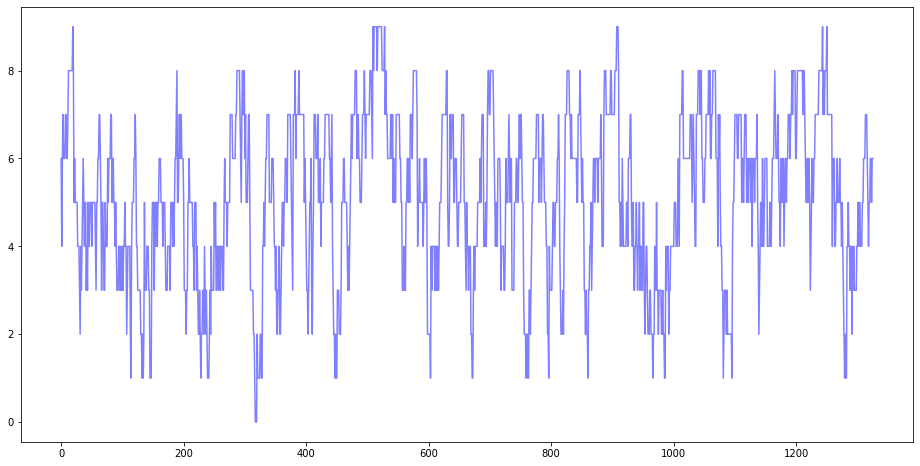

In [521]:
test['rsi_bins'].plot(figsize=(16,8), color='blue', alpha=0.5)
#test['sma_10d'].plot(figsize=(16,8), color='green', alpha=0.5)
#test['sma_20d'].plot(figsize=(16,8), color='red', alpha=0.5)
#test[(test['low_min_d10'] > test['low_min_d10_shift1_10']) 
    #& (test['low_min_d10_shift1_10'] > test['low_min_d10_shift2_20'])
    #& (test['stationary_sma_100d_zscore'] <= (0.8 * test['stationary_sma_100d_zscore_min_all']))
    #& (test['sma_10d'] > test['sma_20d']) ]['close_price_x'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    #& (test['sma_10d_shift'] < test['sma_20d_shift'])

print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    & (test['next_14d_return'] > 1)].count()['index'])

print(test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < test['rsi_175_max_bin'])
    & (test['rsi_bins'] > test['rsi_175_min_bin'])
    & (test['rsi_bins'] < 7)
    & (test['next_14d_return'] < 1)].count()['index'])

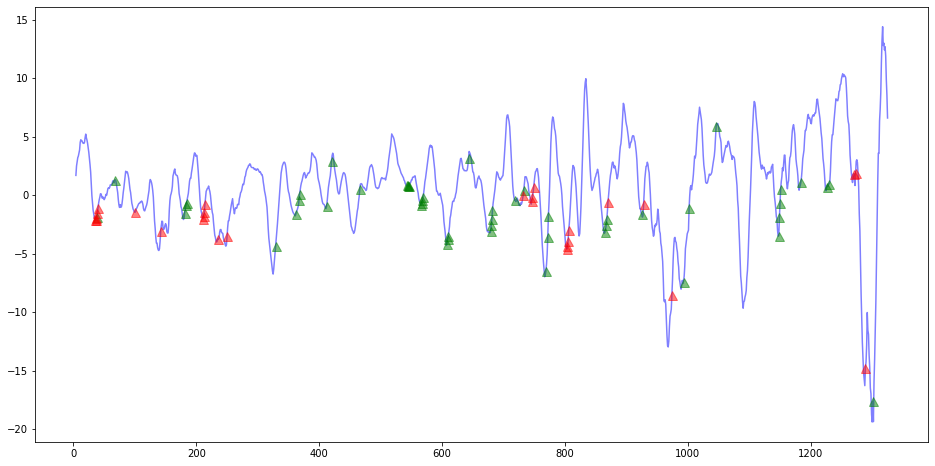

In [492]:
test['sma_10d_coef'].plot(figsize=(16,8), color='blue', alpha=0.5)
test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < 7)
    & (test['next_14d_return'] > 1)]['sma_10d_coef'].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')

test[(test['stationary_sma_10d_zscore_shift_2'] <= (0.8 * test['stationary_sma_10d_zscore_min_all_shift_2']))
    & (test['moving_7d_return'] > 1)
    & (test['rsi_bins'] < 7)
    & (test['next_14d_return'] < 1)]['sma_10d_coef'].plot(linestyle='', marker='^', color='red', alpha = 0.5, markersize = 9, label='Buy Signal 1')


In [543]:
clean_data = 0
df_1 = 0
test = 0
data_frame = 0
data_frame1 = 0
data_frame2 = 0
data_frame3 = 0
data_frame4 = 0

In [544]:


# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df', 205676164),
 ('to_plot', 21999298),
 ('df_today', 11517943),
 ('plot_me', 7175589),
 ('returns', 2269176),
 ('petro_df', 2159190),
 ('returns4', 1598438),
 ('metrics', 686162),
 ('metrics_b', 643794),
 ('metrics_a', 601298),
 ('returns3', 569377),
 ('returns2', 361326),
 ('returns1', 345484),
 ('buy_groups', 131304),
 ('pivot', 68624),
 ('xxx', 34880),
 ('list_of_good', 33000),
 ('df1s', 7992),
 ('my_stocks', 7992),
 ('gains_df', 5504),
 ('last_days_symbol', 2280),
 ('BeautifulSoup', 2008),
 ('ThreadPool', 1064),
 ('timedelta', 400),
 ('heatmap', 200),
 ('backtest', 144),
 ('create_charts_1', 144),
 ('create_charts_2', 144),
 ('create_charts_3', 144),
 ('create_dataframe', 144),
 ('finviz_pull', 144),
 ('get_prices', 144),
 ('mean', 144),
 ('median', 144),
 ('money_maker', 144),
 ('run_indicators_2', 144),
 ('stdev', 144),
 ('yahoo_finance_query', 144),
 ('min_date', 136),
 ('relevant_columns', 128),
 ('colors', 120),
 ('ppp', 96),
 ('symbol', 96),
 ('mp', 88),
 ('np', 88),
 ('